In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import os
from google.protobuf.json_format import MessageToDict
import contract_pb2
from matplotlib.ticker import MaxNLocator

In [2]:
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200

# Instruction
Here below you can enter or edit location to the dir with csvs, jsons, and protobufs.

It is presuposed that the tree of these files is as in test data:

dir_name - csvs
         
         - jsons
         
         - protobufs

In [3]:
dir_name = "RLdata/"
csv_type = "csvs/"
json_type = "jsons/"
protobuf_type = "protobufs/"

In [4]:
def get_all_files_of_type(file_type):
    #list_all_the files:
    path_m = dir_name + file_type

    type_file_names = []
    for root, dirs, files in os.walk(path_m):
        for name in files:
            type_file_names.append(os.path.join(root, name))
            
    return type_file_names

def get_files_of_all_types():
    csv_file_names = get_all_files_of_type(csv_type)
    json_file_names = get_all_files_of_type(json_type)
    protobuf_file_names = get_all_files_of_type(protobuf_type)
    
    return csv_file_names, json_file_names, protobuf_file_names

In [5]:
def edit_detection_scanner_result(d):
    scanners = []
    results = []
    if "detections" in d:
        for i in d["detections"]:
            if "scanner" in i:
                scanners.append("'"+i["scanner"]+"'")
            else:
                scanners.append("''")
            if "result" in i:
                results.append("'"+i["result"]+"'")
            else:
                results.append("''")
        d.pop("detections")
    scanner = "[" + ', '.join(scanners) + "]"
    result = "[" + ', '.join(results) + "]"
    
    d["detections_scanner"] = scanner
    d["detections_result"] = result

    return d


def prepare_to_dataframe(d):
    new_d = dict()
    for i in d:
        new_d[i] = [d[i]]
    return new_d

In [6]:
#get rid of unicode sign in csv.
def remove_u(v):
    result = str(str(v).replace(", u'", ", '").replace("[u'", "['"))
    return result

In [7]:
def read_protobuf(file_name):
    with open(file_name, "rb") as f:
        file_props = contract_pb2.FileProps()
        file_props.ParseFromString(f.read())
    d = MessageToDict(file_props)
    new_d = edit_detection_scanner_result(d)
    prepared_dict = prepare_to_dataframe(new_d)
    proto_df = pd.DataFrame(prepared_dict)
    proto_df.rename(columns = {'detectionCount':'detection_count', 'hasDifference':'has_difference', 
                           'sampleType':'sample_type', 'sampleSize':'sample_size', 
                           'scannerCount':'scanner_count'
                          }, inplace = True)
    proto_df = proto_df.astype(str)
    return proto_df

def read_csv(file_name):
    csv_df = pd.read_csv(file_name)
    csv_df = csv_df.astype(str)
    csv_df['detections_result'] = csv_df['detections.result'].apply(remove_u)
    csv_df['detections_scanner'] = csv_df['detections.scanner'].apply(remove_u)
    csv_df.drop(['detections.scanner', 'detections.result'], axis=1, inplace=True)
    return csv_df

def read_json(file_name):
    json_df = pd.read_json(file_name)
    json_df = json_df.astype(str)
    json_df.rename(columns={'detections.scanner':'detections_scanner', 'detections.result':'detections_result'}, inplace=True)
    return json_df

In [8]:
def get_dataframe_from_file_list(file_list):
    dfs = []
    #print(file_list)
    for file_name in file_list:
        file_type = file_name.split(".")[-1]
        if file_type == "csv":
            read = read_csv
        elif file_type == "json":
            read = read_json
        elif file_type == "protobuf":
            read = read_protobuf
        else:
            continue
        dfs.append(read(file_name))

    df = pd.concat(dfs)
    return df

In [9]:
def get_all_dataframes():
    csv_file_names, json_file_names, protobuf_file_names = get_files_of_all_types()
    csv_df = get_dataframe_from_file_list(csv_file_names)
    json_df = get_dataframe_from_file_list(json_file_names)
    proto_df = get_dataframe_from_file_list(protobuf_file_names)
    
    return csv_df, json_df, proto_df

In [10]:
def get_same_columns_from_two_dfs(df1, df2):
    column_names_1 = [i for i in df1.columns]
    column_names_2 = [i for i in df2.columns]

    same_columns = list(set(column_names_1).intersection(column_names_2))

    return same_columns

def get_different_from_first(df1, df2):
    column_names_1 = [i for i in df1]
    column_names_2 = [i for i in df2]
    only_first = list(set(column_names_1).difference(column_names_2))
    return only_first

In [11]:
def get_unique_columns(df):
    no_of_rows = df.shape[0]
    uniques = df.nunique().reset_index()
    uniq_columns = []
    
    for i in uniques.index:
        name = uniques["index"][i]
        no_of_uniq = uniques[0][i]
        
        if no_of_uniq == no_of_rows:
            uniq_columns.append(name)
            
    return uniq_columns

In [12]:
def calculate_difference_per_columns(df, equal_columns_names):
    s = dict()
    column = equal_columns_names[0]
    total = len(df[column].index)
    for column in equal_columns_names:
        new_column_name = column.replace("_equal", "")
        s[new_column_name] =  total - df[column].sum()
    columns_error_sum_sorted = pd.DataFrame(sorted(s.items(), key=lambda x: -x[1]))
    columns_error_sum_sorted.rename(columns={0:"difference", 1:"value"}, inplace=True)
    return columns_error_sum_sorted

In [13]:
def get_same_columns_dfs(df1, df2, report=True, language="en"):
    same_columns = get_same_columns_from_two_dfs(df1, df2)
    only_first = get_different_from_first(df1, df2)
    only_second = get_different_from_first(df2, df1)
    if report:
        if language.lower()=='en':
            print("report: " + "Number of shared columns: {0}".format(len(same_columns)))
            print("report: " + "Names of the shared columns:\n" + str(same_columns))
            if len(only_first) > 0:
                print("report: " + "Only first df columns:\n" + str(only_first))
            else:
                print("report: " + "All columns from first df are contained in second df.")
            if len(only_second) > 0:
                print("report: " + "Only second df columns:\n" + str(only_second))
            else:
                print("report: " + "All columns from second df are contained in first df.")
        else:
            print("report: " + "Broj isti stupaca: {0}".format(len(same_columns)))
            print("report: " + "Nazivi istih stupaca:\n" + str(same_columns))
            if len(only_first) > 0:
                print("report: " + "Stupaci samo u prvom:\n" + str(only_first))
            else:
                print("report: " + "Sve kolone iz prvog df-a su sadržane u drugom df-u")
            if len(only_second) > 0:
                print("report: " + "Stupaci samo u drugom:\n" + str(only_second))
            else:
                print("report: " + "Sve kolone iz drugog df-a su sadržane u prvom df-u")
        print()
        
    return same_columns

def get_uniques_df(df1, df2, same_columns, report=True, language="en"):
    first_uniques = get_unique_columns(df1)
    second_uniques = get_unique_columns(df2)
    
    same_uniques = list(set(first_uniques).intersection(second_uniques))
    non_unique_columns = list(set(same_columns).difference(same_uniques))
    if report:
        if language.lower()=='en':
            print("report: " + "Unique columns, possible pk, in both dfs are:\n" + str(same_uniques))
            print("report: " + "Non-Unique columns, used to compare differences are:\n" + str(non_unique_columns))
        else:
            print("report: " + "Uniq kolone, kandidati za pk, iz oba df-a su:\n" + str(same_uniques))
            print("report: " + "Ne-Uniq kolone, po kojima ćemo gledati razlikovanja su:\n" + str(non_unique_columns))
        print()
        
    return same_uniques, non_unique_columns

def merge_dfs(df1, df2, same_columns, same_uniques, report=True, language="en"):
    df = pd.merge(df1[same_columns], df2[same_columns], 
              on=same_uniques, 
              how='outer', indicator='Exist')
    if report:
        if language.lower()=='en':
            print("report: " + "There are {0} rows/pks contained in both dfs."
                  .format(len(df[df['Exist']=='both'])))
            print("report: " + "There are {0} rows/pks contained in first df only."
                  .format(len(df[df['Exist']=='left_only'])))
            print("report: " + "There are {0} rows/pks contained in second df only."
                  .format(len(df[df['Exist']=='right_only'])))
        else:
            print("report: " + "Postoji {0} redaka/ključeva koji se nalaze u oba df-a."
                  .format(len(df[df['Exist']=='both'])))
            print("report: " + "Postoji {0} redaka/ključeva koji se nalaze samo u prvom df-u."
                  .format(len(df[df['Exist']=='left_only'])))
            print("report: " + "Postoji {0} redaka/ključeva koji se nalaze samo u drugom df-u."
                  .format(len(df[df['Exist']=='right_only'])))
        print()
        
    return df

def get_equals_in_df(df, non_unique_columns, report=True, language="en"):
    df = df.astype(str)
    equal_columns_names = []
    for column_name in non_unique_columns:
        equal_columns_names.append(column_name+"_equal")
        df[column_name+"_equal"] = df.apply(lambda x: x[column_name+'_y'] == x[column_name+'_x'], axis=1)
    
    df["n_equals"] = df.apply(lambda x: x[equal_columns_names].sum(), axis=1)
    df["n_diff"] = df.apply(lambda x: len(equal_columns_names)-x[equal_columns_names].sum(), axis=1)
    
    inner_df = df[df["Exist"]=='both']
    if report:
        for i in range(len(non_unique_columns)+1):
            difference = len(inner_df[inner_df["n_diff"]==i])
            if language.lower()=='en':
                if i == 0:
                    print("report: " + "Number of rows with all identical columns is {0}.".format(difference))
                else:
                    if difference == 0:
                        print("report: " + "There are no rows with {1} different columns.".format(difference, i))
                    else:
                        print("report: " + "Number of rows with {1} different columns is {0}.".format(difference, i))
            else:
                if i == 0:
                    print("report: " + "Postoji {0} redaka sa svim identičnim kolonama.".format(difference))
                else:
                    if difference == 0:
                        print("report: " + "Ne postoji redak s {1} različitih kolona.".format(difference, i))
                    else:
                        print("report: " + "Postoji {0} redaka s {1} različitih kolona.".format(difference, i))
        print()
        
    return inner_df, equal_columns_names

def get_comparison_per_column(inner_df, equal_columns_names, report=True, language="en"):
    columns_error_sum_sorted = calculate_difference_per_columns(inner_df, equal_columns_names)
    if report:
        for i in columns_error_sum_sorted.index:
            if language.lower()=='en':
                print("report: " + "Column {0} contains {1} differences across the table.".
                      format(columns_error_sum_sorted["difference"][i], columns_error_sum_sorted["value"][i]))
            else:
                print("report: " + "U stupcu {0} postoji {1} razlika.".format(columns_error_sum_sorted["difference"][i],
                                                                      columns_error_sum_sorted["value"][i]))
        print()
        
    return columns_error_sum_sorted

def compare_two_df(df1, df2, report=True):
    
    same_columns = get_same_columns_dfs(df1, df2, report)
    
    same_uniques, non_unique_columns = get_uniques_df(df1, df2, same_columns, report)
        
    df = merge_dfs(df1, df2, same_columns, same_uniques, report)
        
    inner_df, equal_columns_names = get_equals_in_df(df, non_unique_columns, report)
                
    columns_error_sum_sorted = get_comparison_per_column(inner_df, equal_columns_names, report)
    
    return inner_df, columns_error_sum_sorted

In [14]:
def compare_three_dfs(df1, df2, df3, report=True):
    same_columns = get_same_columns_dfs(df1, df2, report=False)
    same_uniques, non_unique_columns = get_uniques_df(df1, df2, same_columns, report=False)
    df_12 = pd.merge(df1[same_columns], df2[same_columns], 
          on=same_columns, 
          how='inner', indicator='Exist')

    return compare_two_df(df_12, df3, report)

In [15]:
csv_df, json_df, proto_df = get_all_dataframes()

# CSV JSON comparison

In [16]:
csv_json_df, csv_json_cols = compare_two_df(csv_df, json_df)

report: Number of shared columns: 11
report: Names of the shared columns:
['scanner_count', 'detections_scanner', 'sha256', 'detections_result', 'classification', 'sha1', 'md5', 'sample_type', 'has_difference', 'detection_count', 'sample_size']
report: Only first df columns:
['level']
report: All columns from second df are contained in first df.

report: Unique columns, possible pk, in both dfs are:
['sha256', 'sha1', 'md5']
report: Non-Unique columns, used to compare differences are:
['scanner_count', 'detections_scanner', 'detections_result', 'classification', 'sample_type', 'has_difference', 'detection_count', 'sample_size']

report: There are 996 rows/pks contained in both dfs.
report: There are 0 rows/pks contained in first df only.
report: There are 4 rows/pks contained in second df only.

report: Number of rows with all identical columns is 797.
report: Number of rows with 1 different columns is 194.
report: Number of rows with 2 different columns is 5.
report: There are no rows

# CSV PROTOBUF comparison

In [17]:
csv_proto_df, csv_proto_cols = compare_two_df(csv_df, proto_df)

report: Number of shared columns: 11
report: Names of the shared columns:
['scanner_count', 'detections_scanner', 'sha256', 'detections_result', 'classification', 'sha1', 'md5', 'sample_type', 'has_difference', 'detection_count', 'sample_size']
report: Only first df columns:
['level']
report: All columns from second df are contained in first df.

report: Unique columns, possible pk, in both dfs are:
['sha256', 'sha1', 'md5']
report: Non-Unique columns, used to compare differences are:
['scanner_count', 'detections_scanner', 'detections_result', 'classification', 'sample_type', 'has_difference', 'detection_count', 'sample_size']

report: There are 992 rows/pks contained in both dfs.
report: There are 4 rows/pks contained in first df only.
report: There are 4 rows/pks contained in second df only.

report: Number of rows with all identical columns is 797.
report: Number of rows with 1 different columns is 188.
report: Number of rows with 2 different columns is 7.
report: There are no rows

# JSON PROTOBUF comparison

In [18]:
json_proto_df, json_proto_cols = compare_two_df(json_df, proto_df, report=True)

report: Number of shared columns: 11
report: Names of the shared columns:
['scanner_count', 'detections_scanner', 'sha256', 'detections_result', 'classification', 'sha1', 'md5', 'sample_type', 'has_difference', 'detection_count', 'sample_size']
report: All columns from first df are contained in second df.
report: All columns from second df are contained in first df.

report: Unique columns, possible pk, in both dfs are:
['sha256', 'sha1', 'md5']
report: Non-Unique columns, used to compare differences are:
['scanner_count', 'detections_scanner', 'detections_result', 'classification', 'sample_type', 'has_difference', 'detection_count', 'sample_size']

report: There are 996 rows/pks contained in both dfs.
report: There are 4 rows/pks contained in first df only.
report: There are 0 rows/pks contained in second df only.

report: Number of rows with all identical columns is 950.
report: Number of rows with 1 different columns is 44.
report: Number of rows with 2 different columns is 2.
repor

# Comparison of all three: JSON PROTOBUF CSV

In [19]:
final_df, final_columns = compare_three_dfs(json_df, proto_df, csv_df, report=True)

report: Number of shared columns: 11
report: Names of the shared columns:
['scanner_count', 'detections_scanner', 'sha256', 'detections_result', 'classification', 'sha1', 'md5', 'sample_type', 'has_difference', 'detection_count', 'sample_size']
report: Only first df columns:
['Exist']
report: Only second df columns:
['level']

report: Unique columns, possible pk, in both dfs are:
['sha256', 'sha1', 'md5']
report: Non-Unique columns, used to compare differences are:
['scanner_count', 'detections_scanner', 'detections_result', 'classification', 'sample_type', 'has_difference', 'detection_count', 'sample_size']

report: There are 946 rows/pks contained in both dfs.
report: There are 4 rows/pks contained in first df only.
report: There are 50 rows/pks contained in second df only.

report: Number of rows with all identical columns is 776.
report: Number of rows with 1 different columns is 168.
report: Number of rows with 2 different columns is 2.
report: There are no rows with 3 different c

In [20]:
def plot_number_of_difference_per_row_in_percent(df):
    s = df[df['n_diff']>0]["n_diff"].shape[0]
    s2 = df["n_diff"].shape[0]
    plt.hist(np.array(df[df['n_diff']>0]["n_diff"]), edgecolor = 'black', weights=np.ones(s)/s2)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Histogram of differences per row')
    plt.xlabel('Number of different columns in single row')
    plt.ylabel('Total percentage of rows')
    plt.show()

def plot_total_number_of_difference_per_row_in_percent(df):
    s = df["n_diff"].shape[0]
    plt.hist(np.array(df["n_diff"]), edgecolor = 'black', weights=np.ones(s)/s, log=True)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Histogram of differences per row (no-differences included)')
    plt.xlabel('Number of different columns in single row')
    plt.ylabel('Total percentage of rows')
    plt.show()

In [21]:
def plot_difference_per_column(col_err):
    plt.bar(col_err.index, col_err["value"], tick_label=list(col_err["difference"]))
    plt.xticks(rotation='vertical')
    plt.title('Histogram of differences per column')
    plt.xlabel('Name of the column')
    plt.ylabel('Number of rows where this column is different')
    plt.show()

def plot_difference_per_column_in_percent(col_err):
    plt.bar(col_err.index, col_err["value"]/sum(col_err["value"]), 
            tick_label=list(col_err["difference"]),  
        edgecolor = 'black')
    plt.xticks(rotation='vertical')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title('Histogram of differences per column')
    plt.xlabel('Name of the column')
    plt.ylabel('Percentage of rows where this column is different (given only non-identical rows)')
    plt.show()

# Visual Comparison of CSV and JSON data

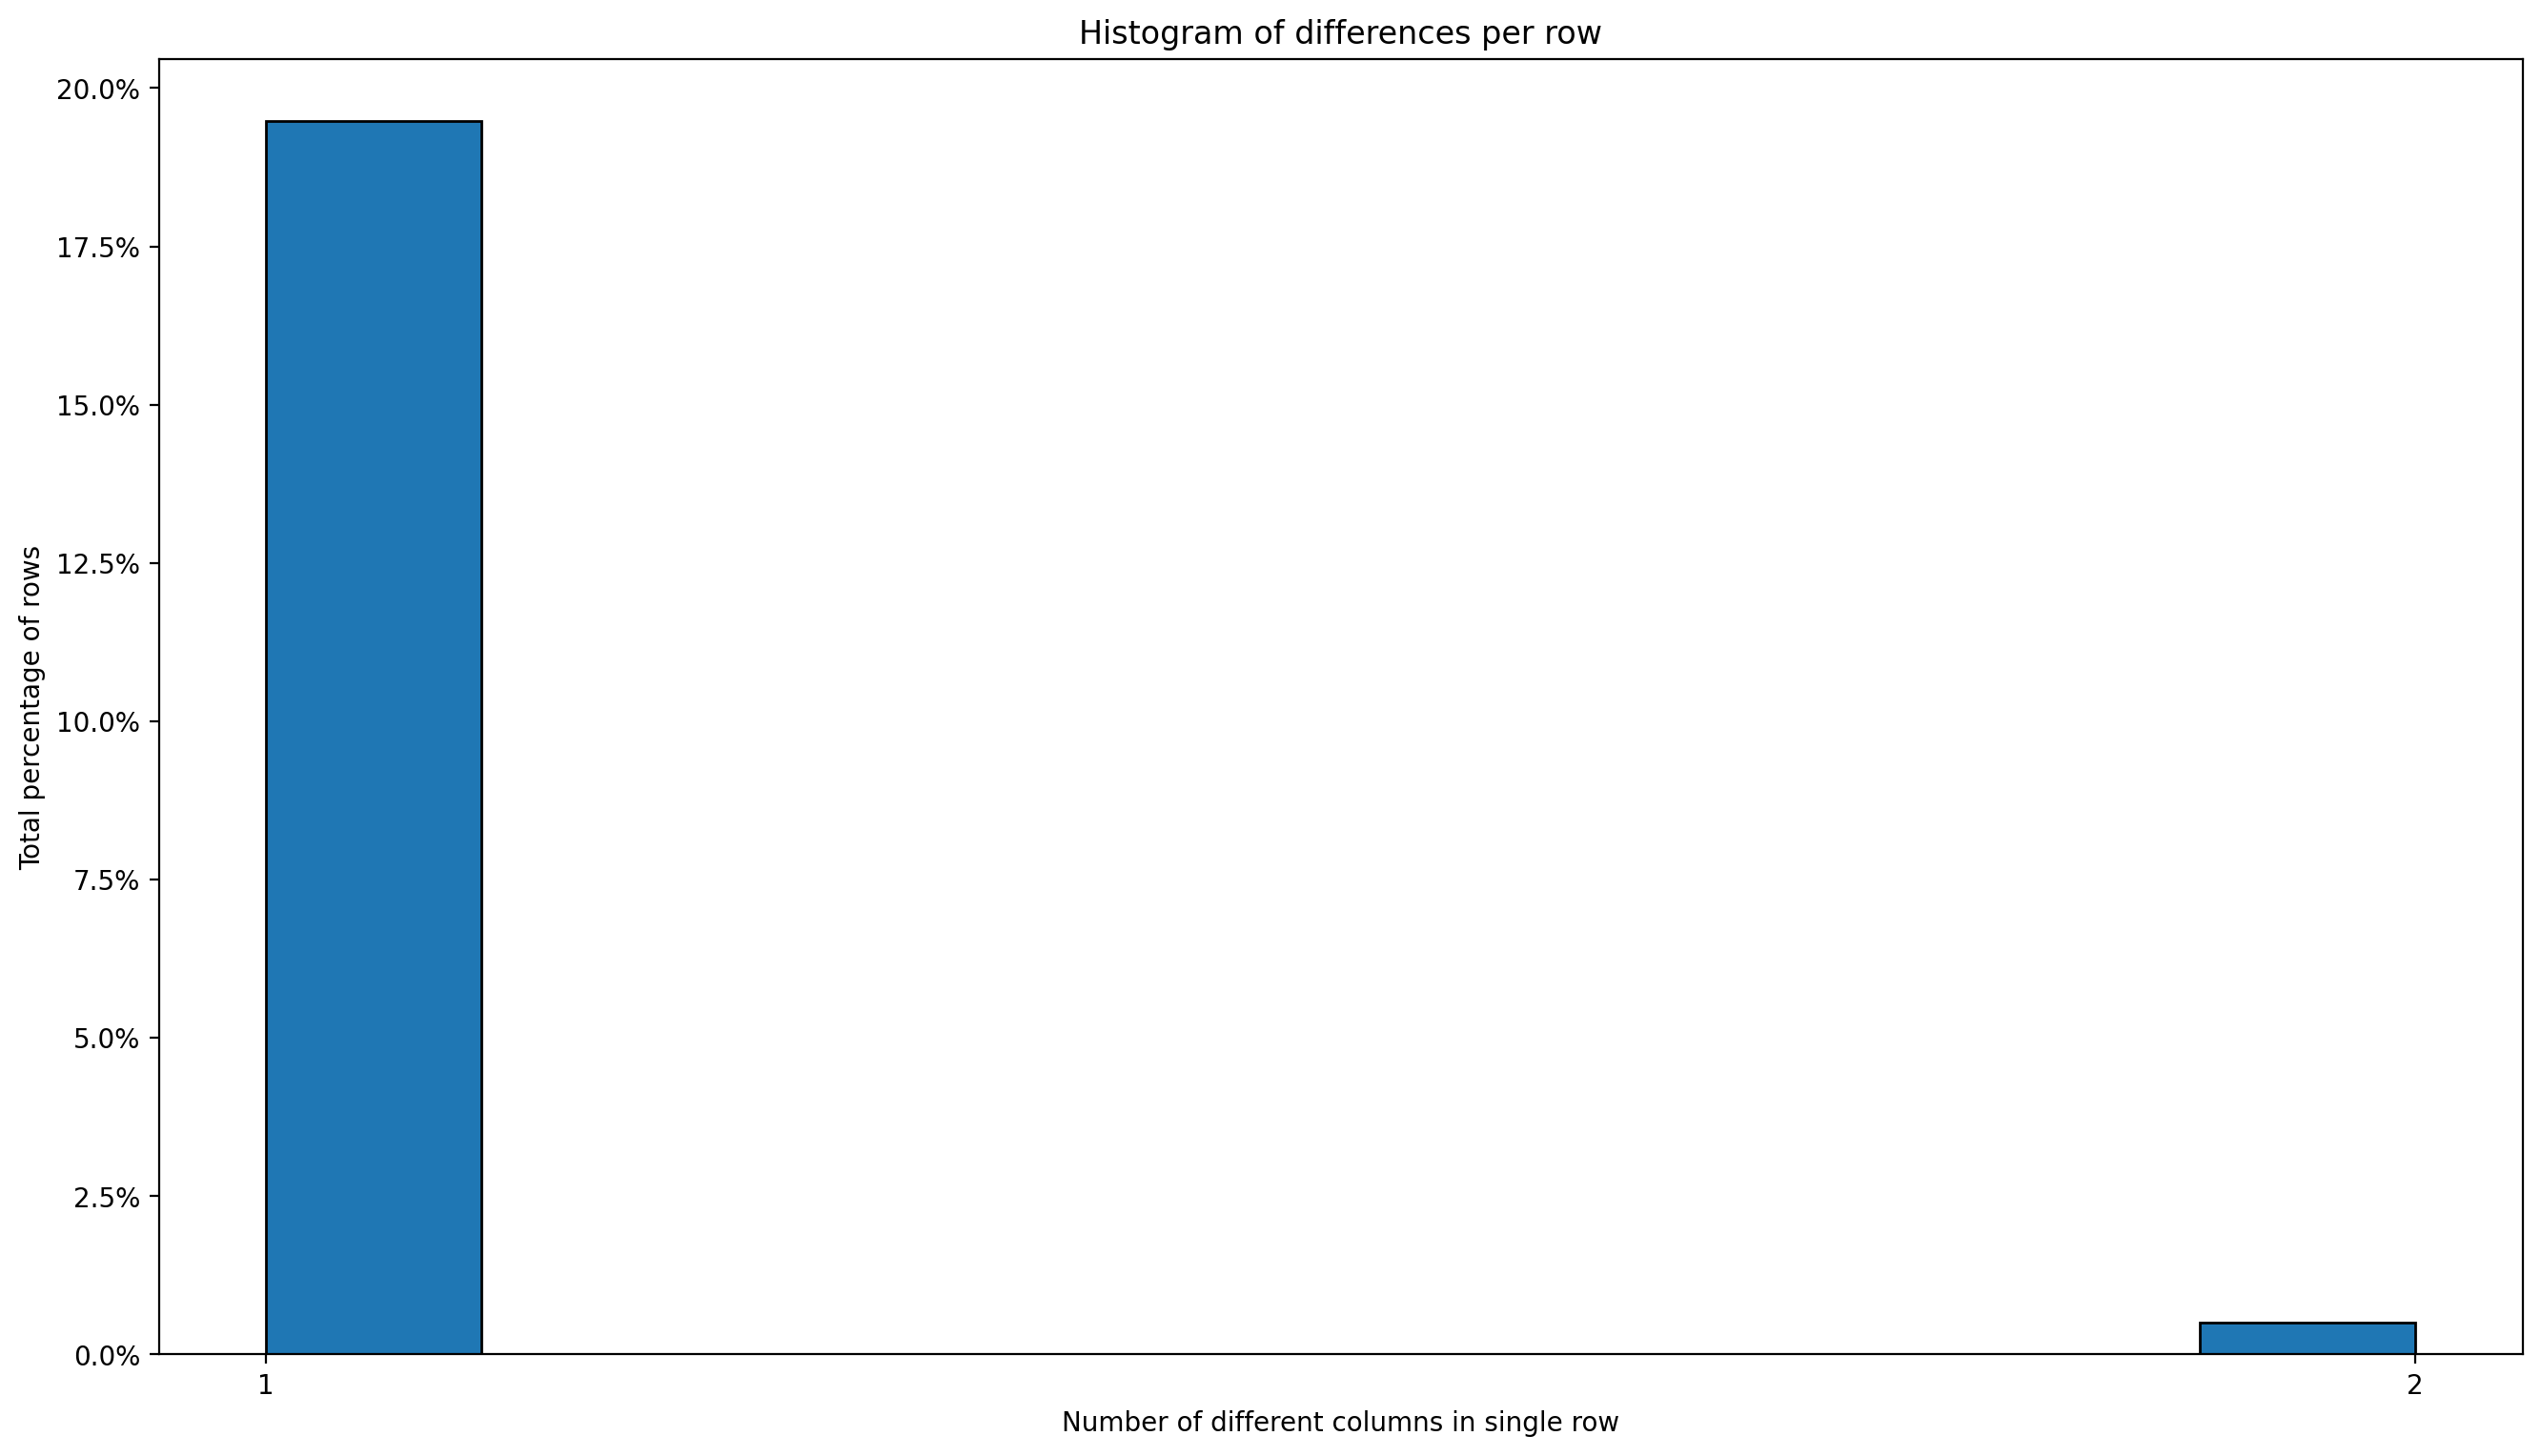

In [22]:
plot_number_of_difference_per_row_in_percent(csv_json_df)

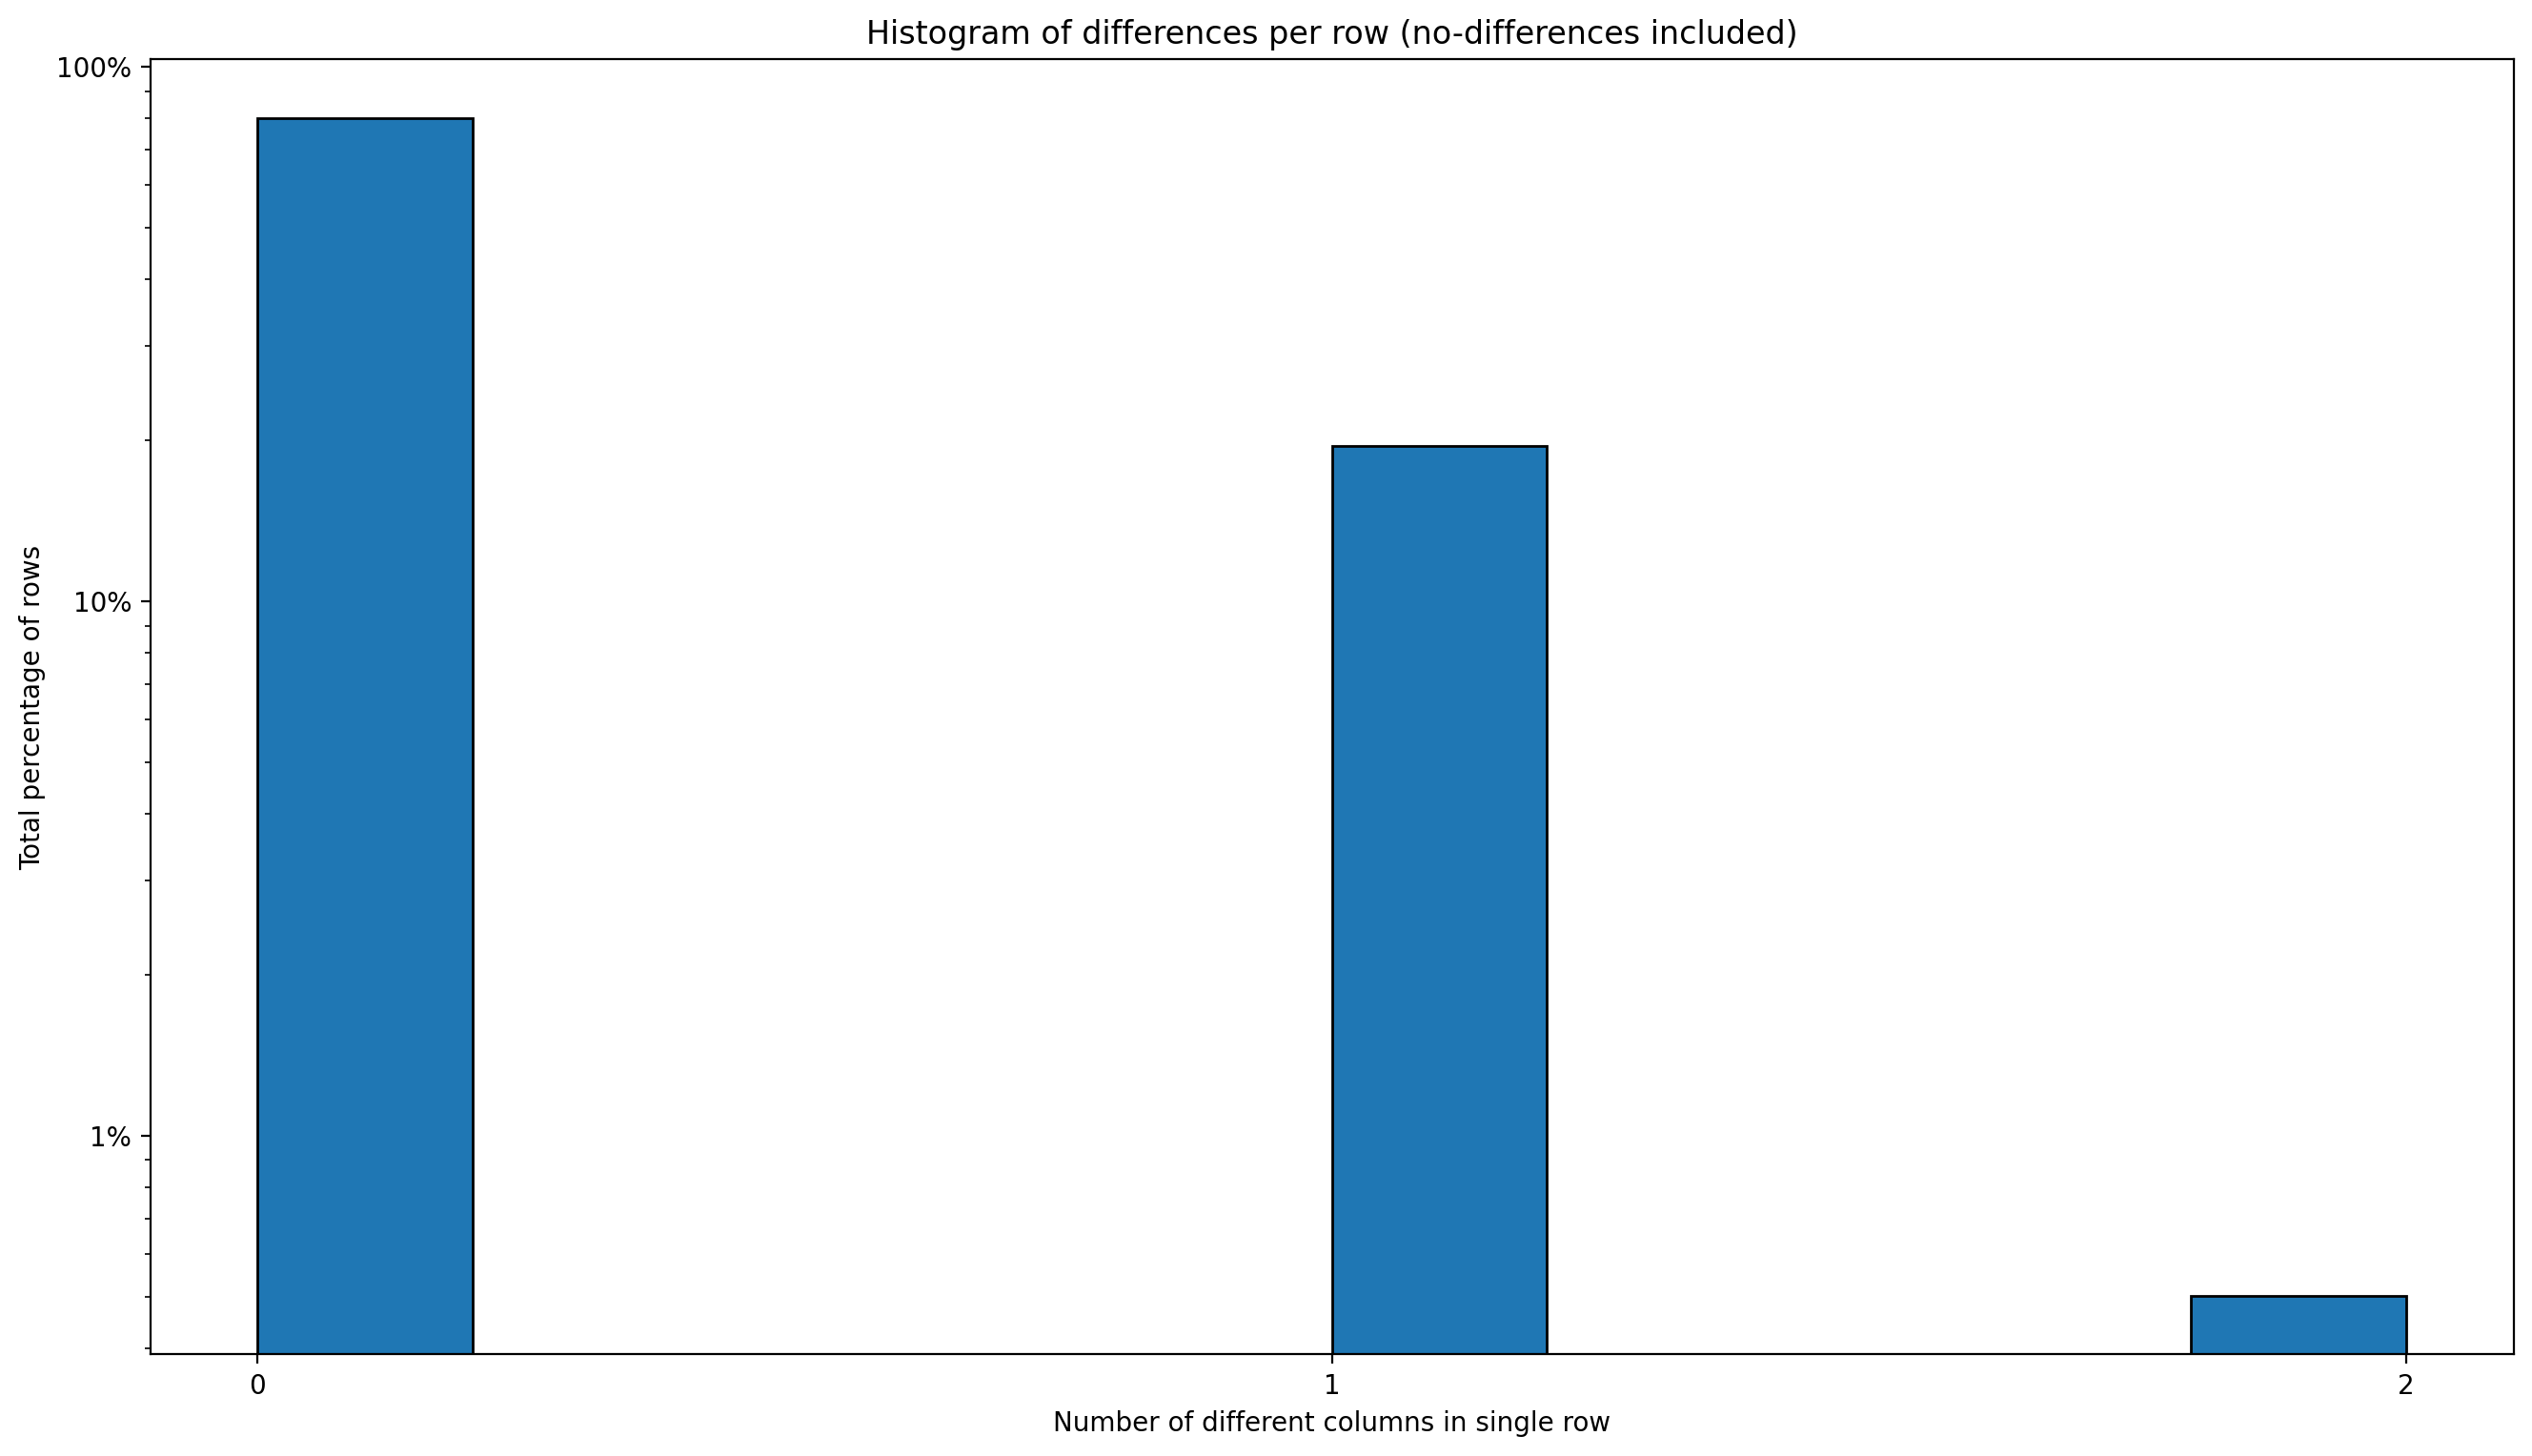

In [23]:
plot_total_number_of_difference_per_row_in_percent(csv_json_df)

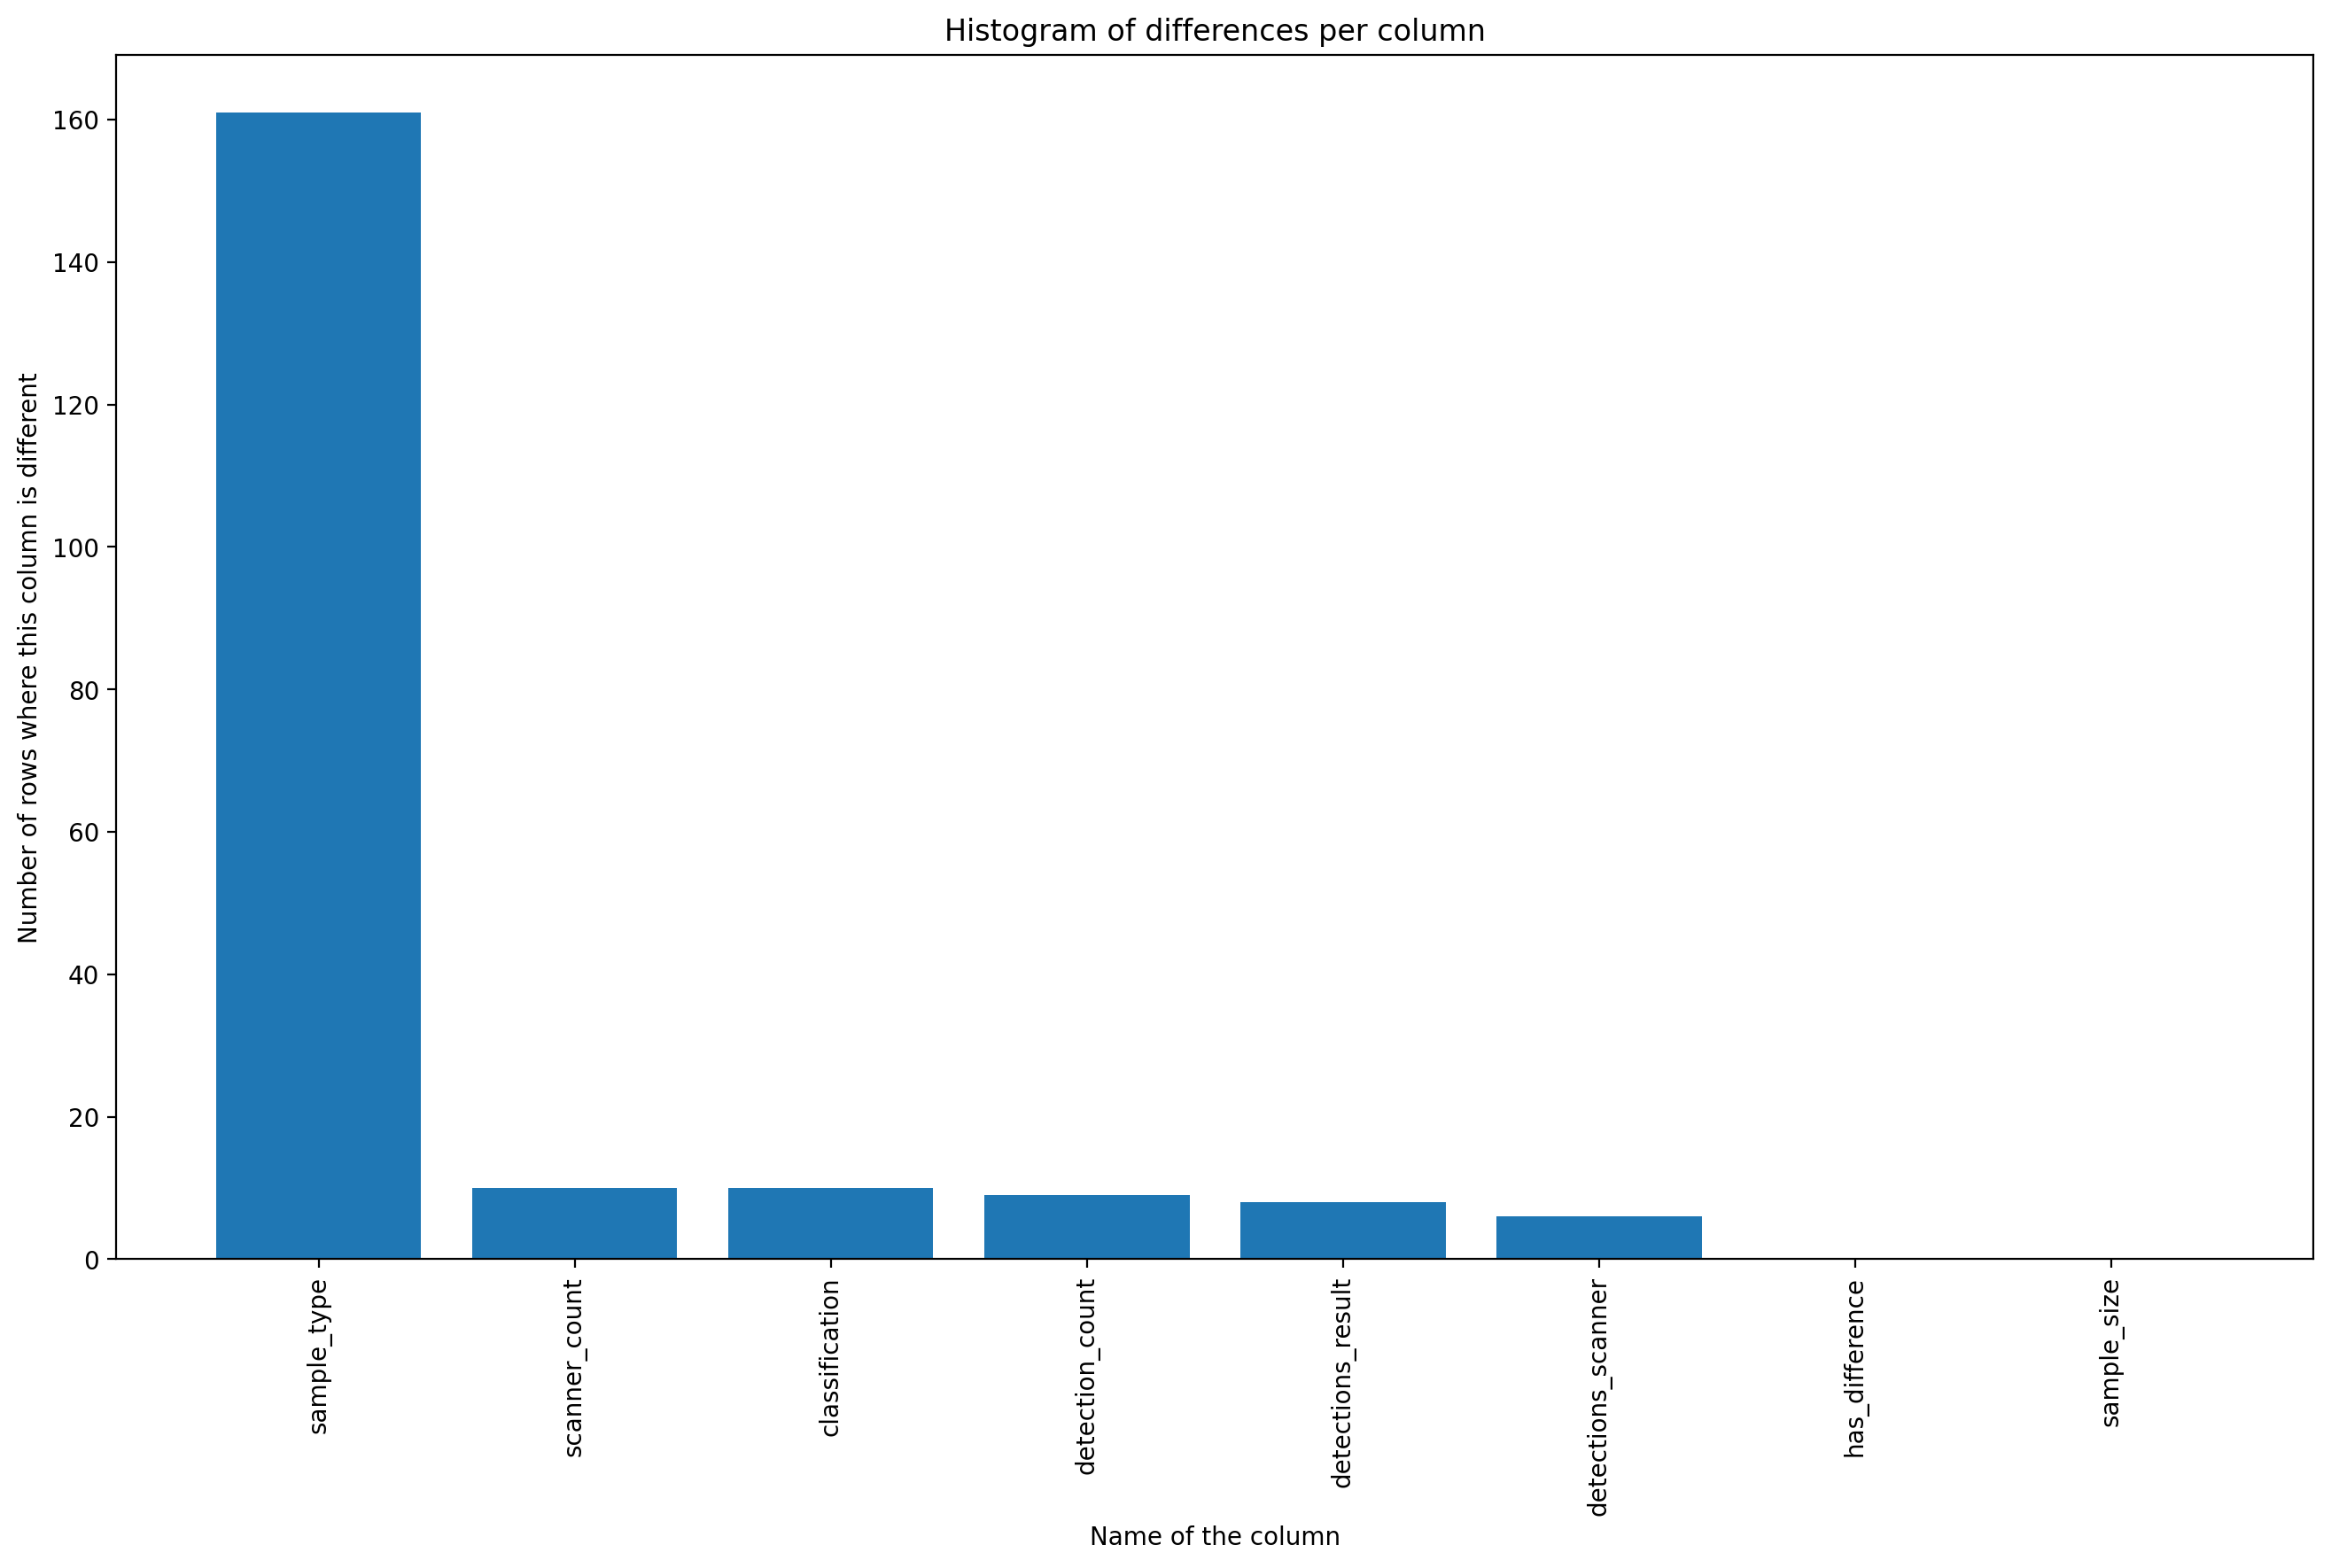

In [24]:
plot_difference_per_column(csv_json_cols)

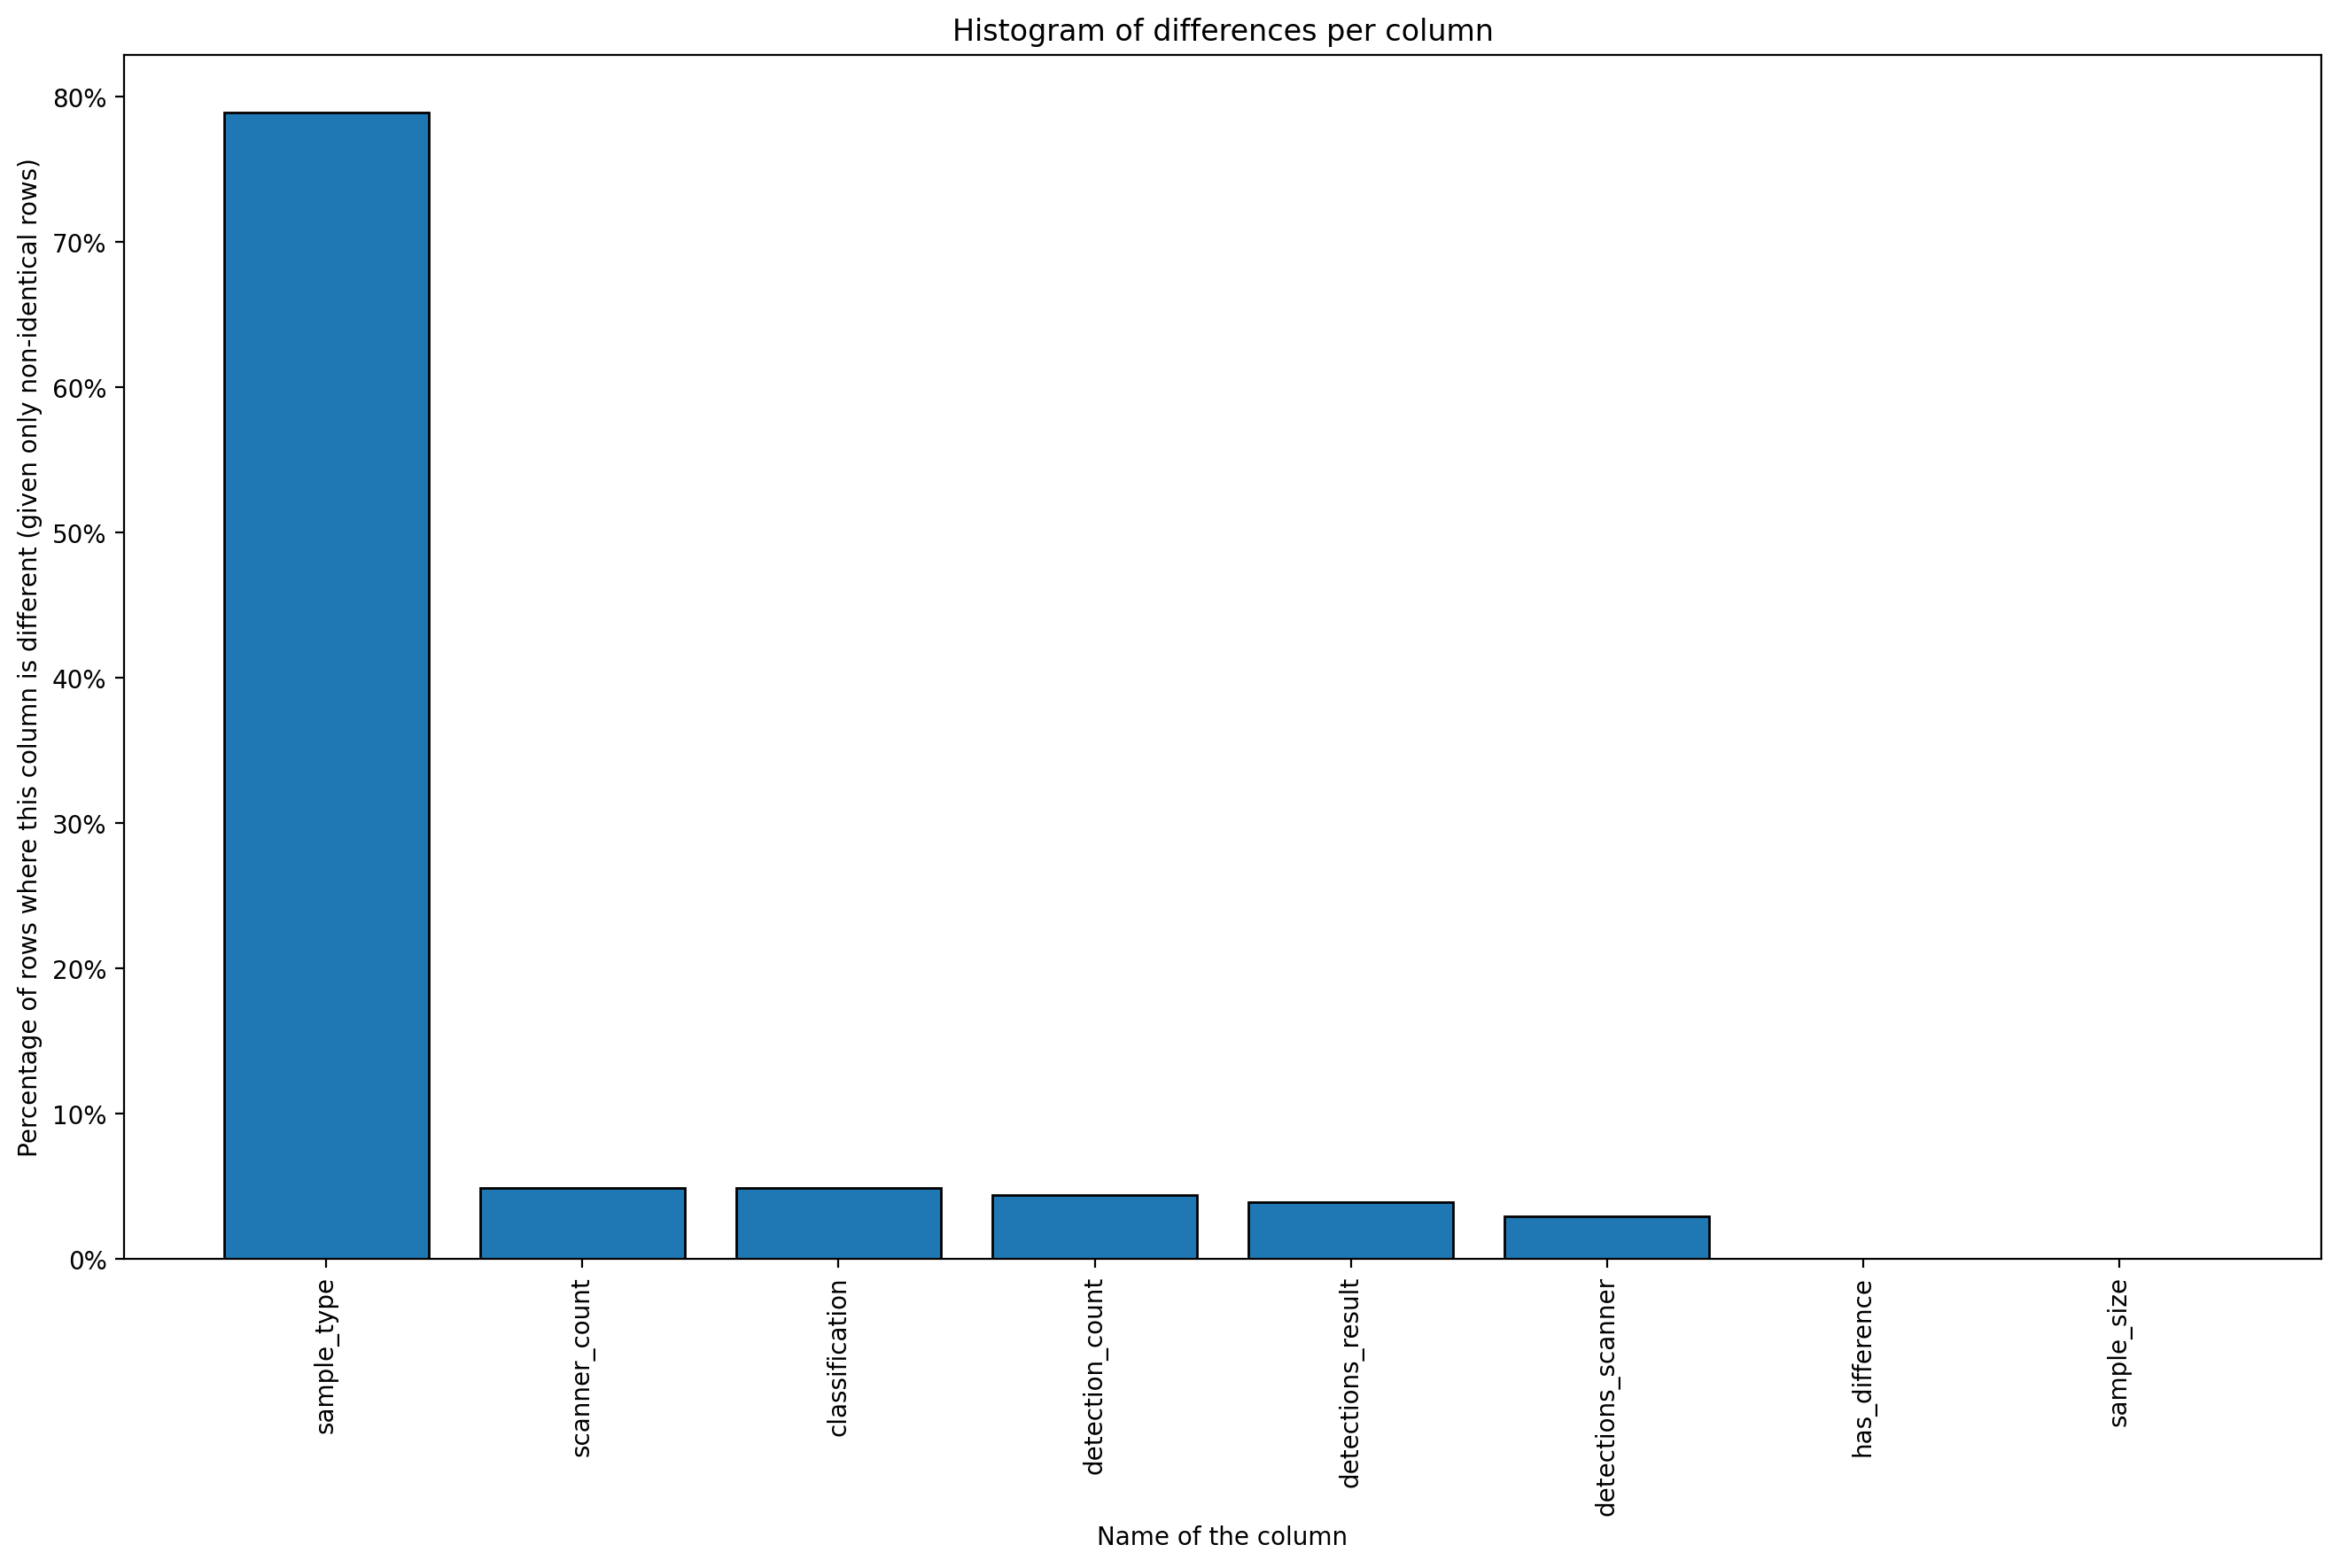

In [25]:
plot_difference_per_column_in_percent(csv_json_cols)

# Visual Comparison of CSV and PROTOBUF data

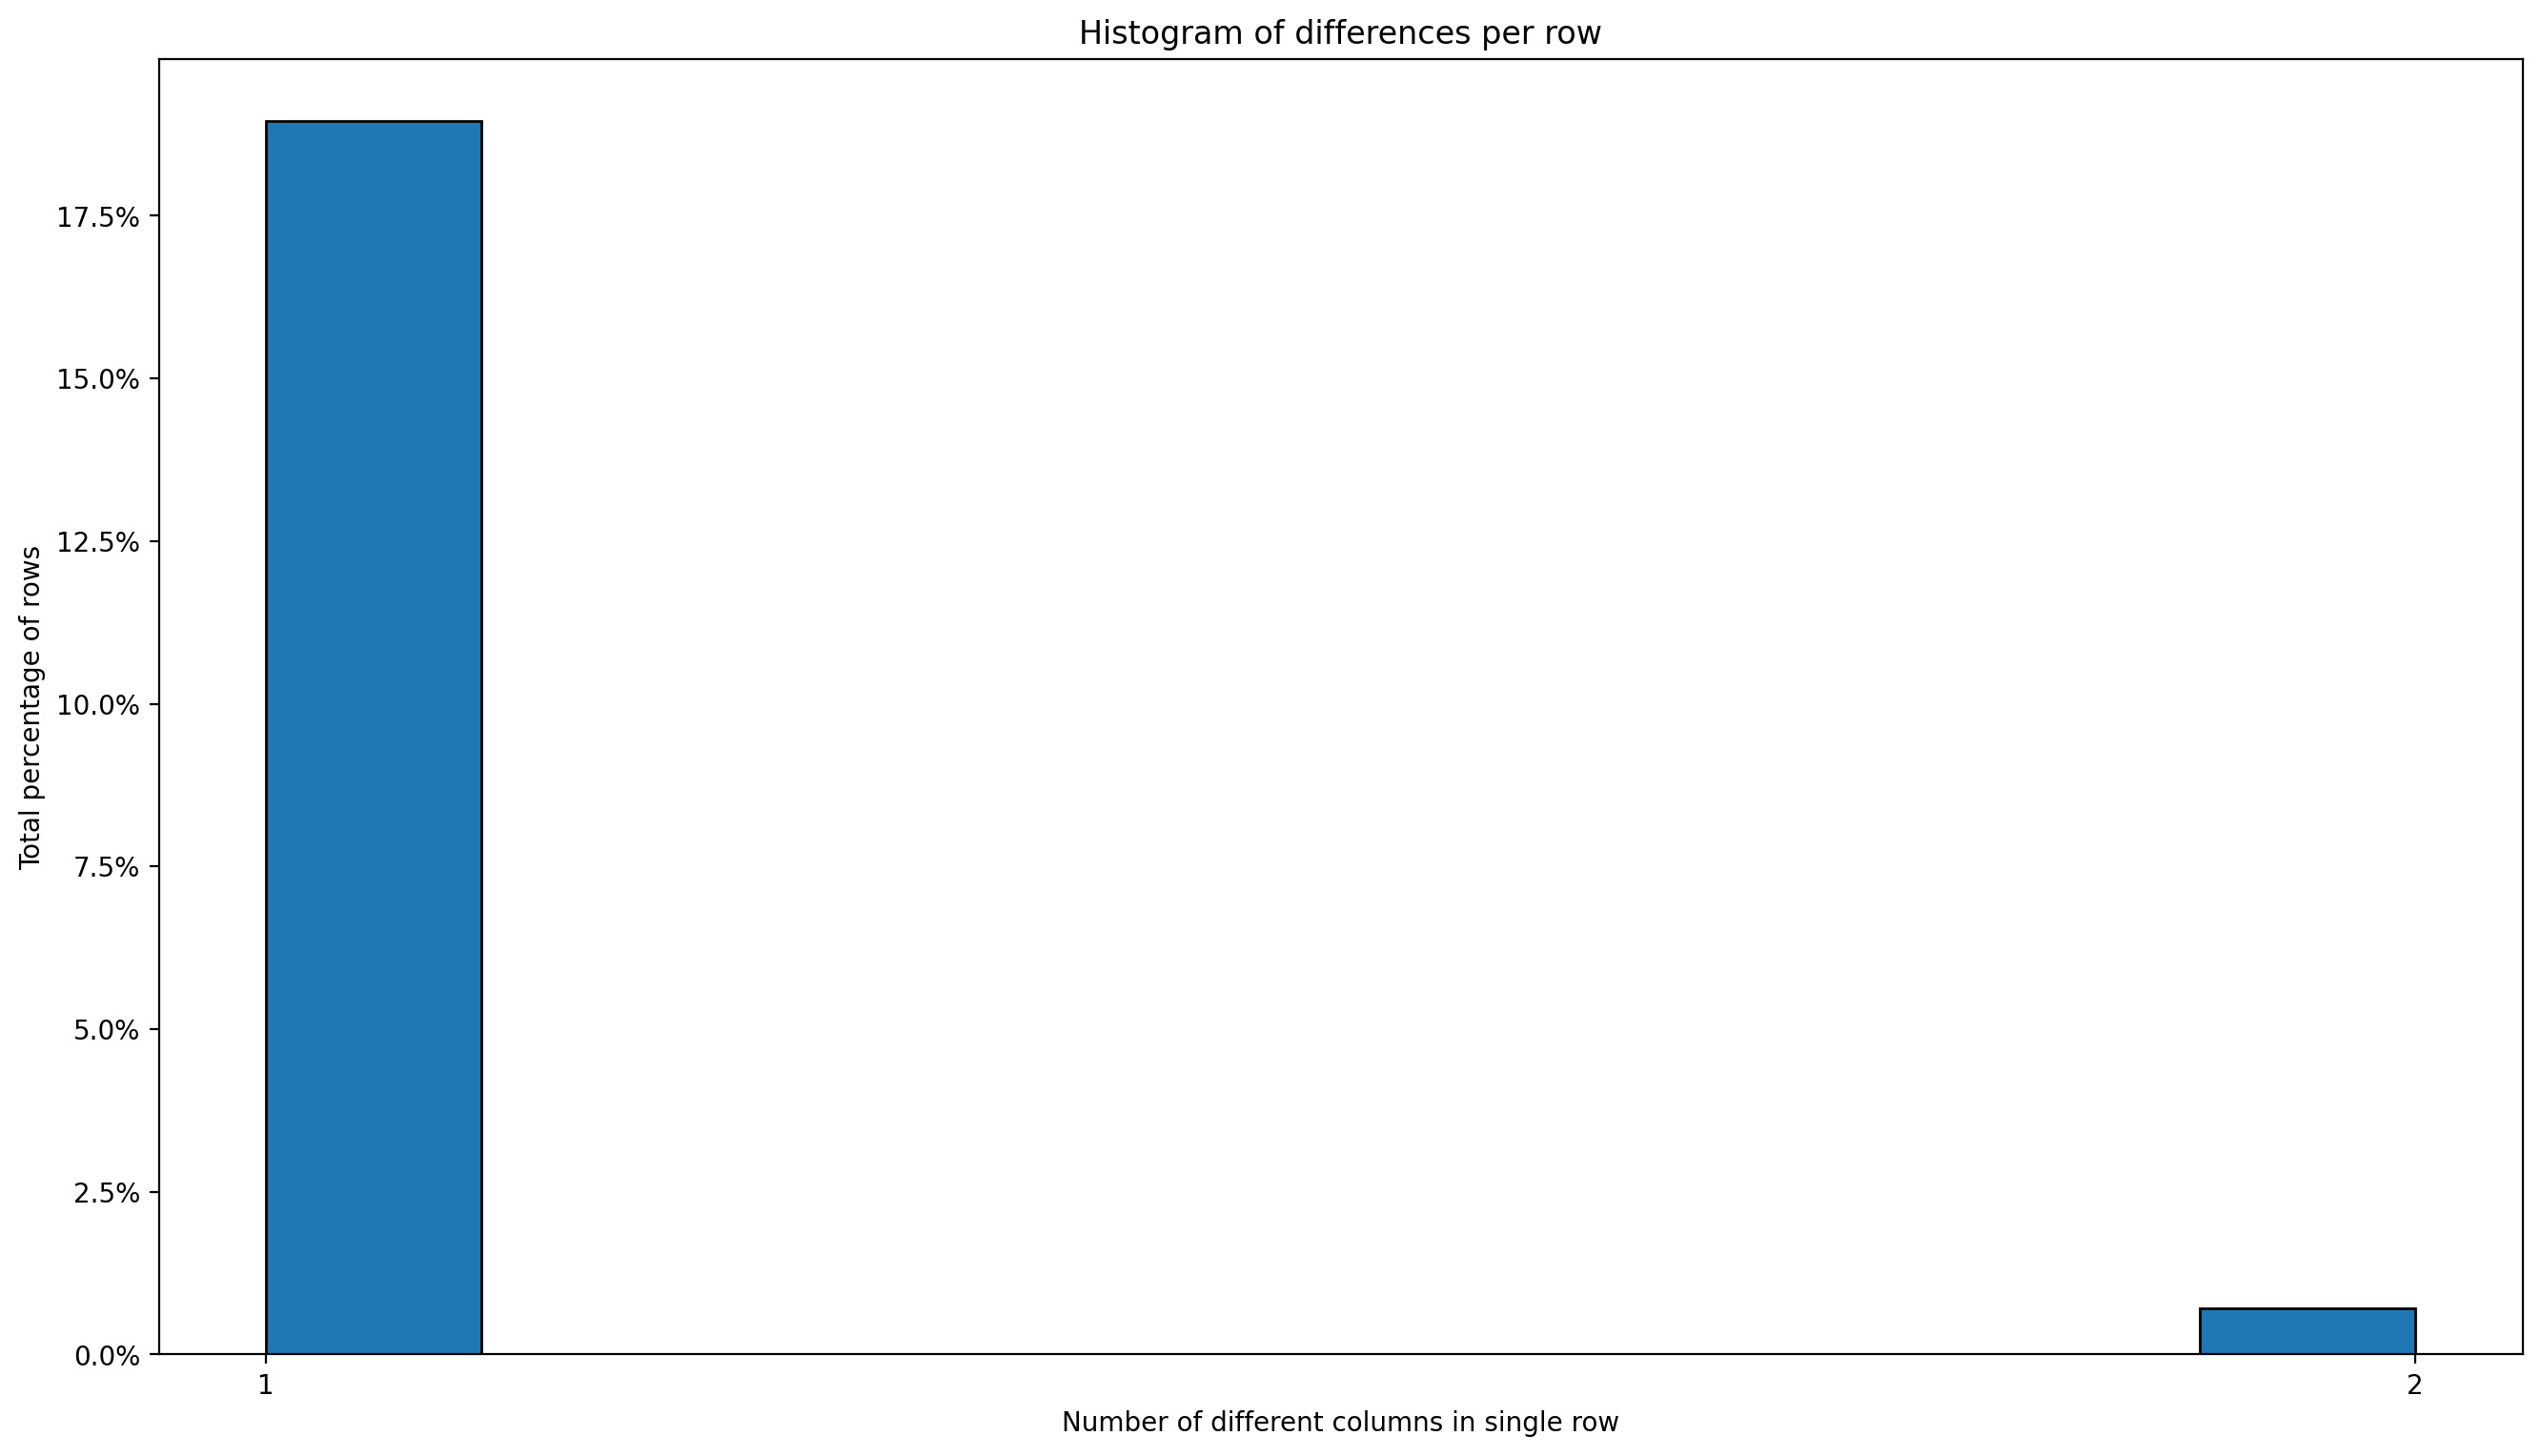

In [26]:
plot_number_of_difference_per_row_in_percent(csv_proto_df)

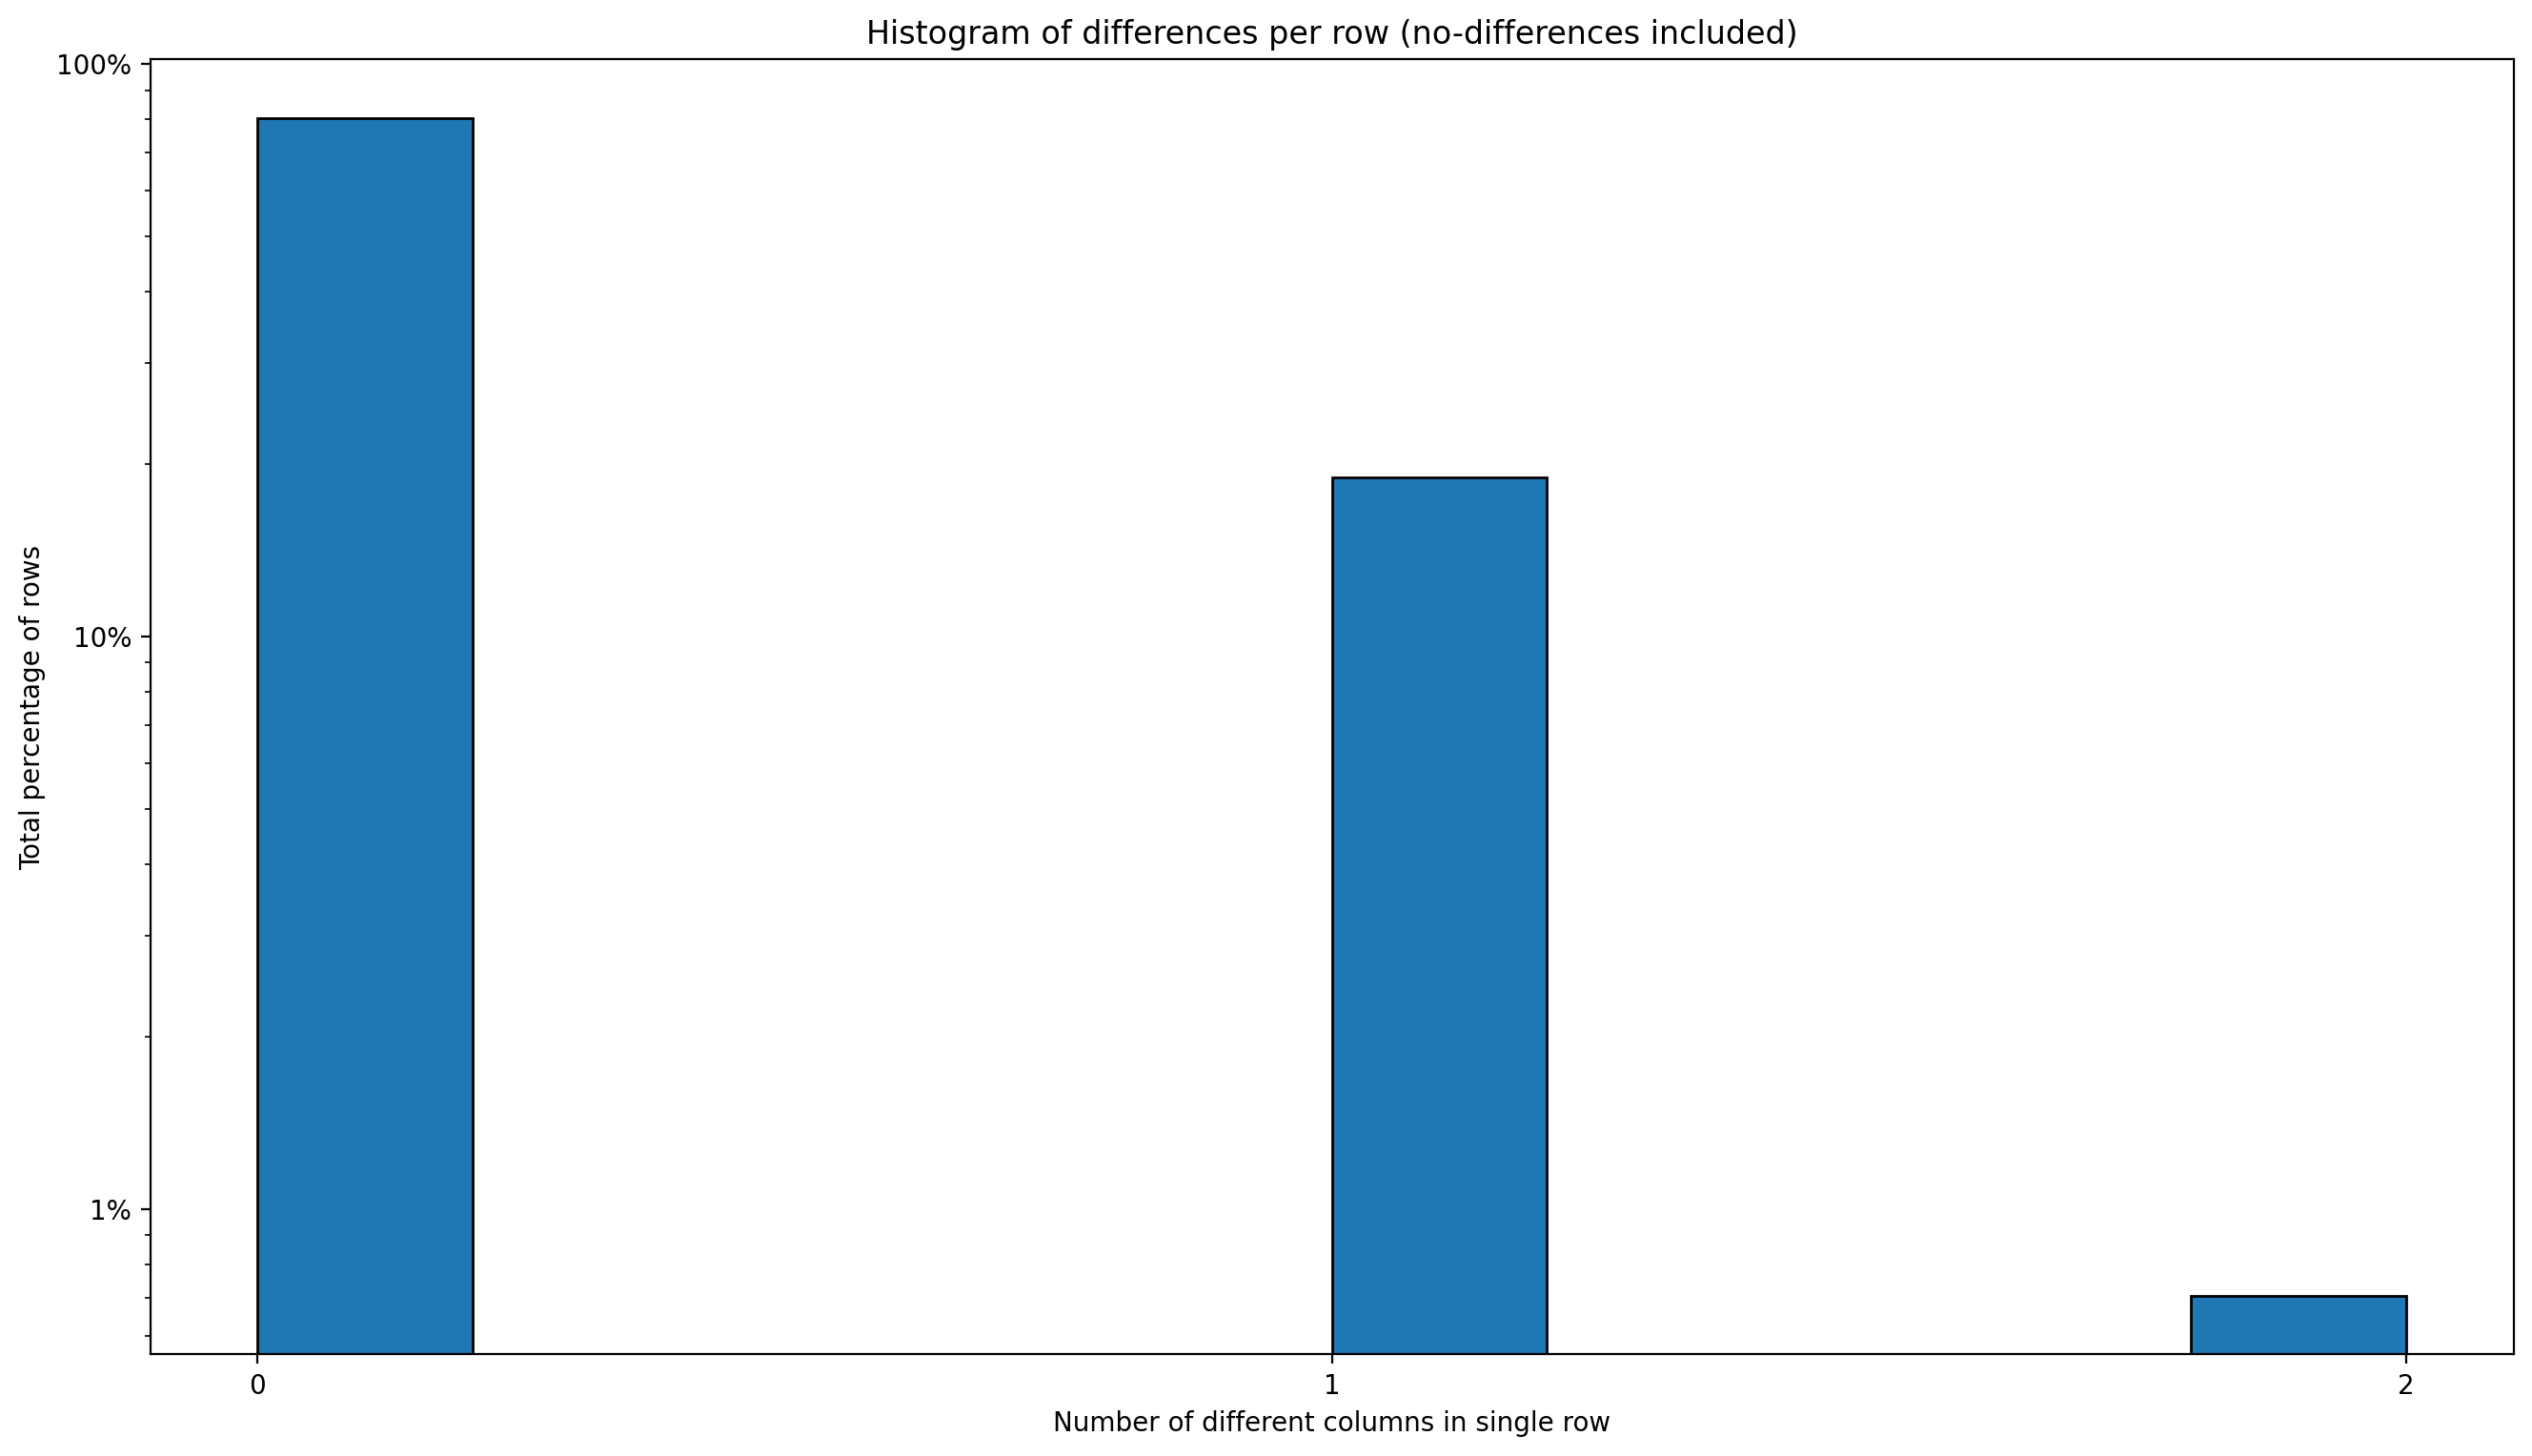

In [27]:
plot_total_number_of_difference_per_row_in_percent(csv_proto_df)

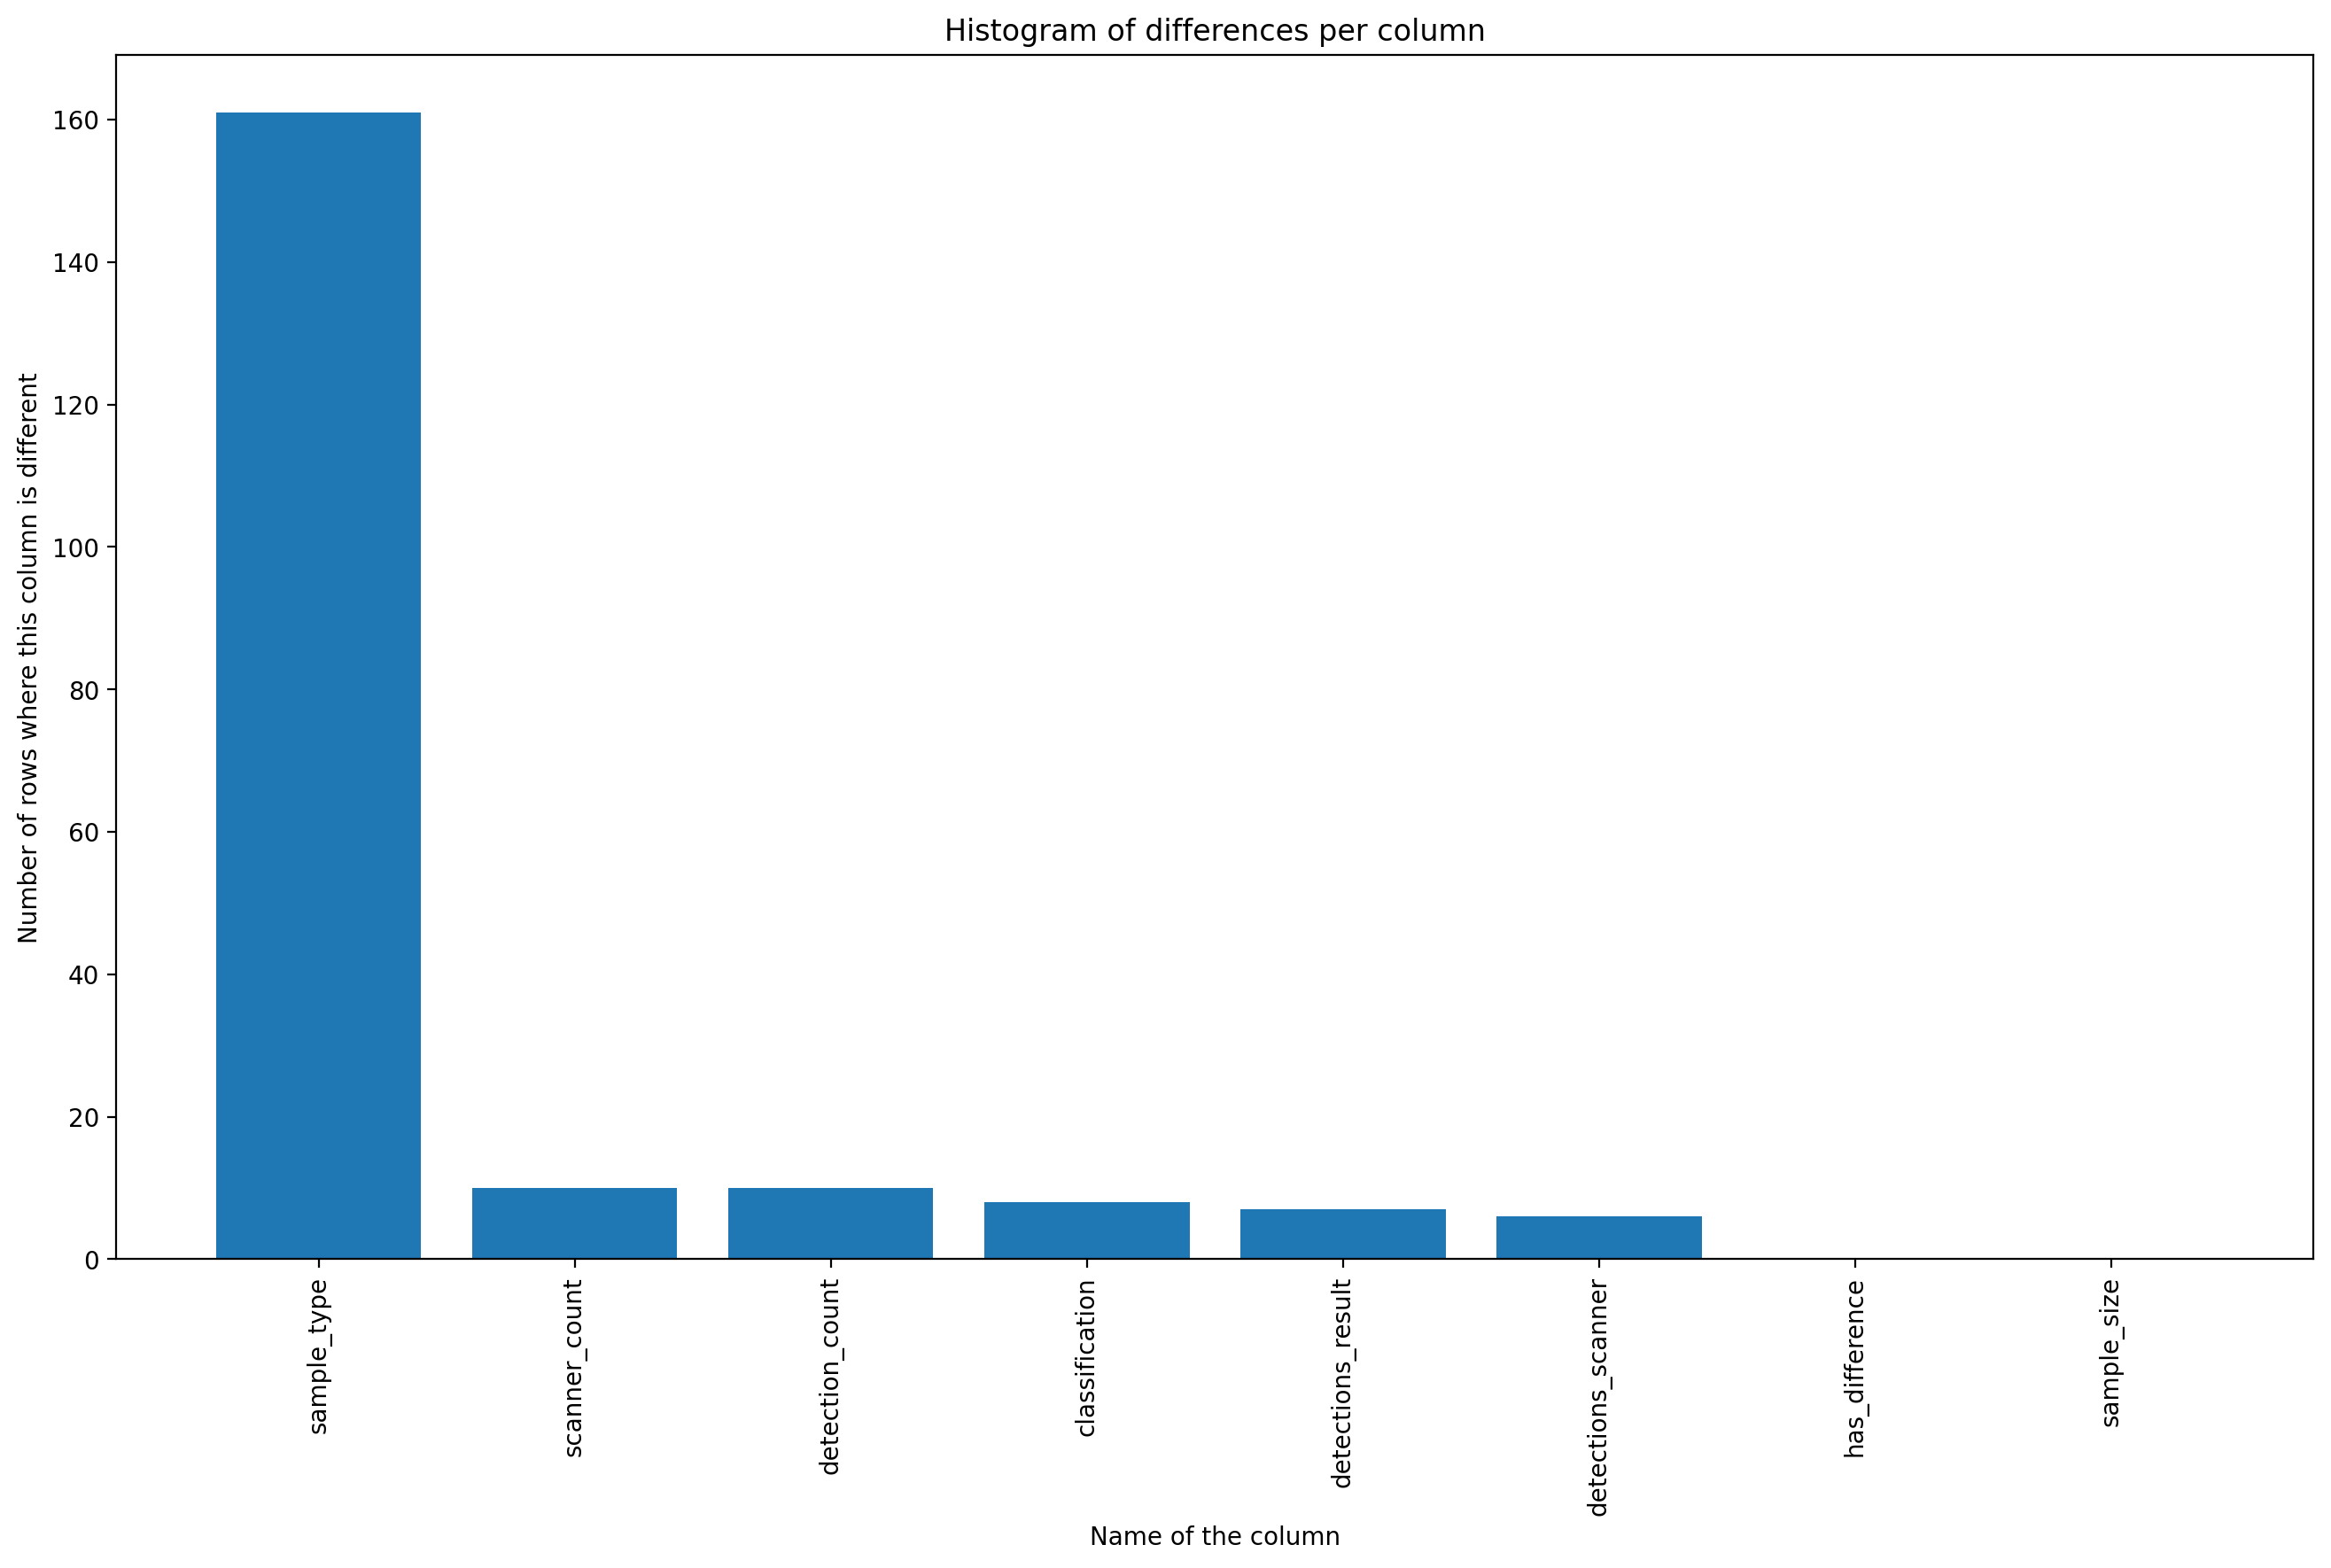

In [28]:
plot_difference_per_column(csv_proto_cols)

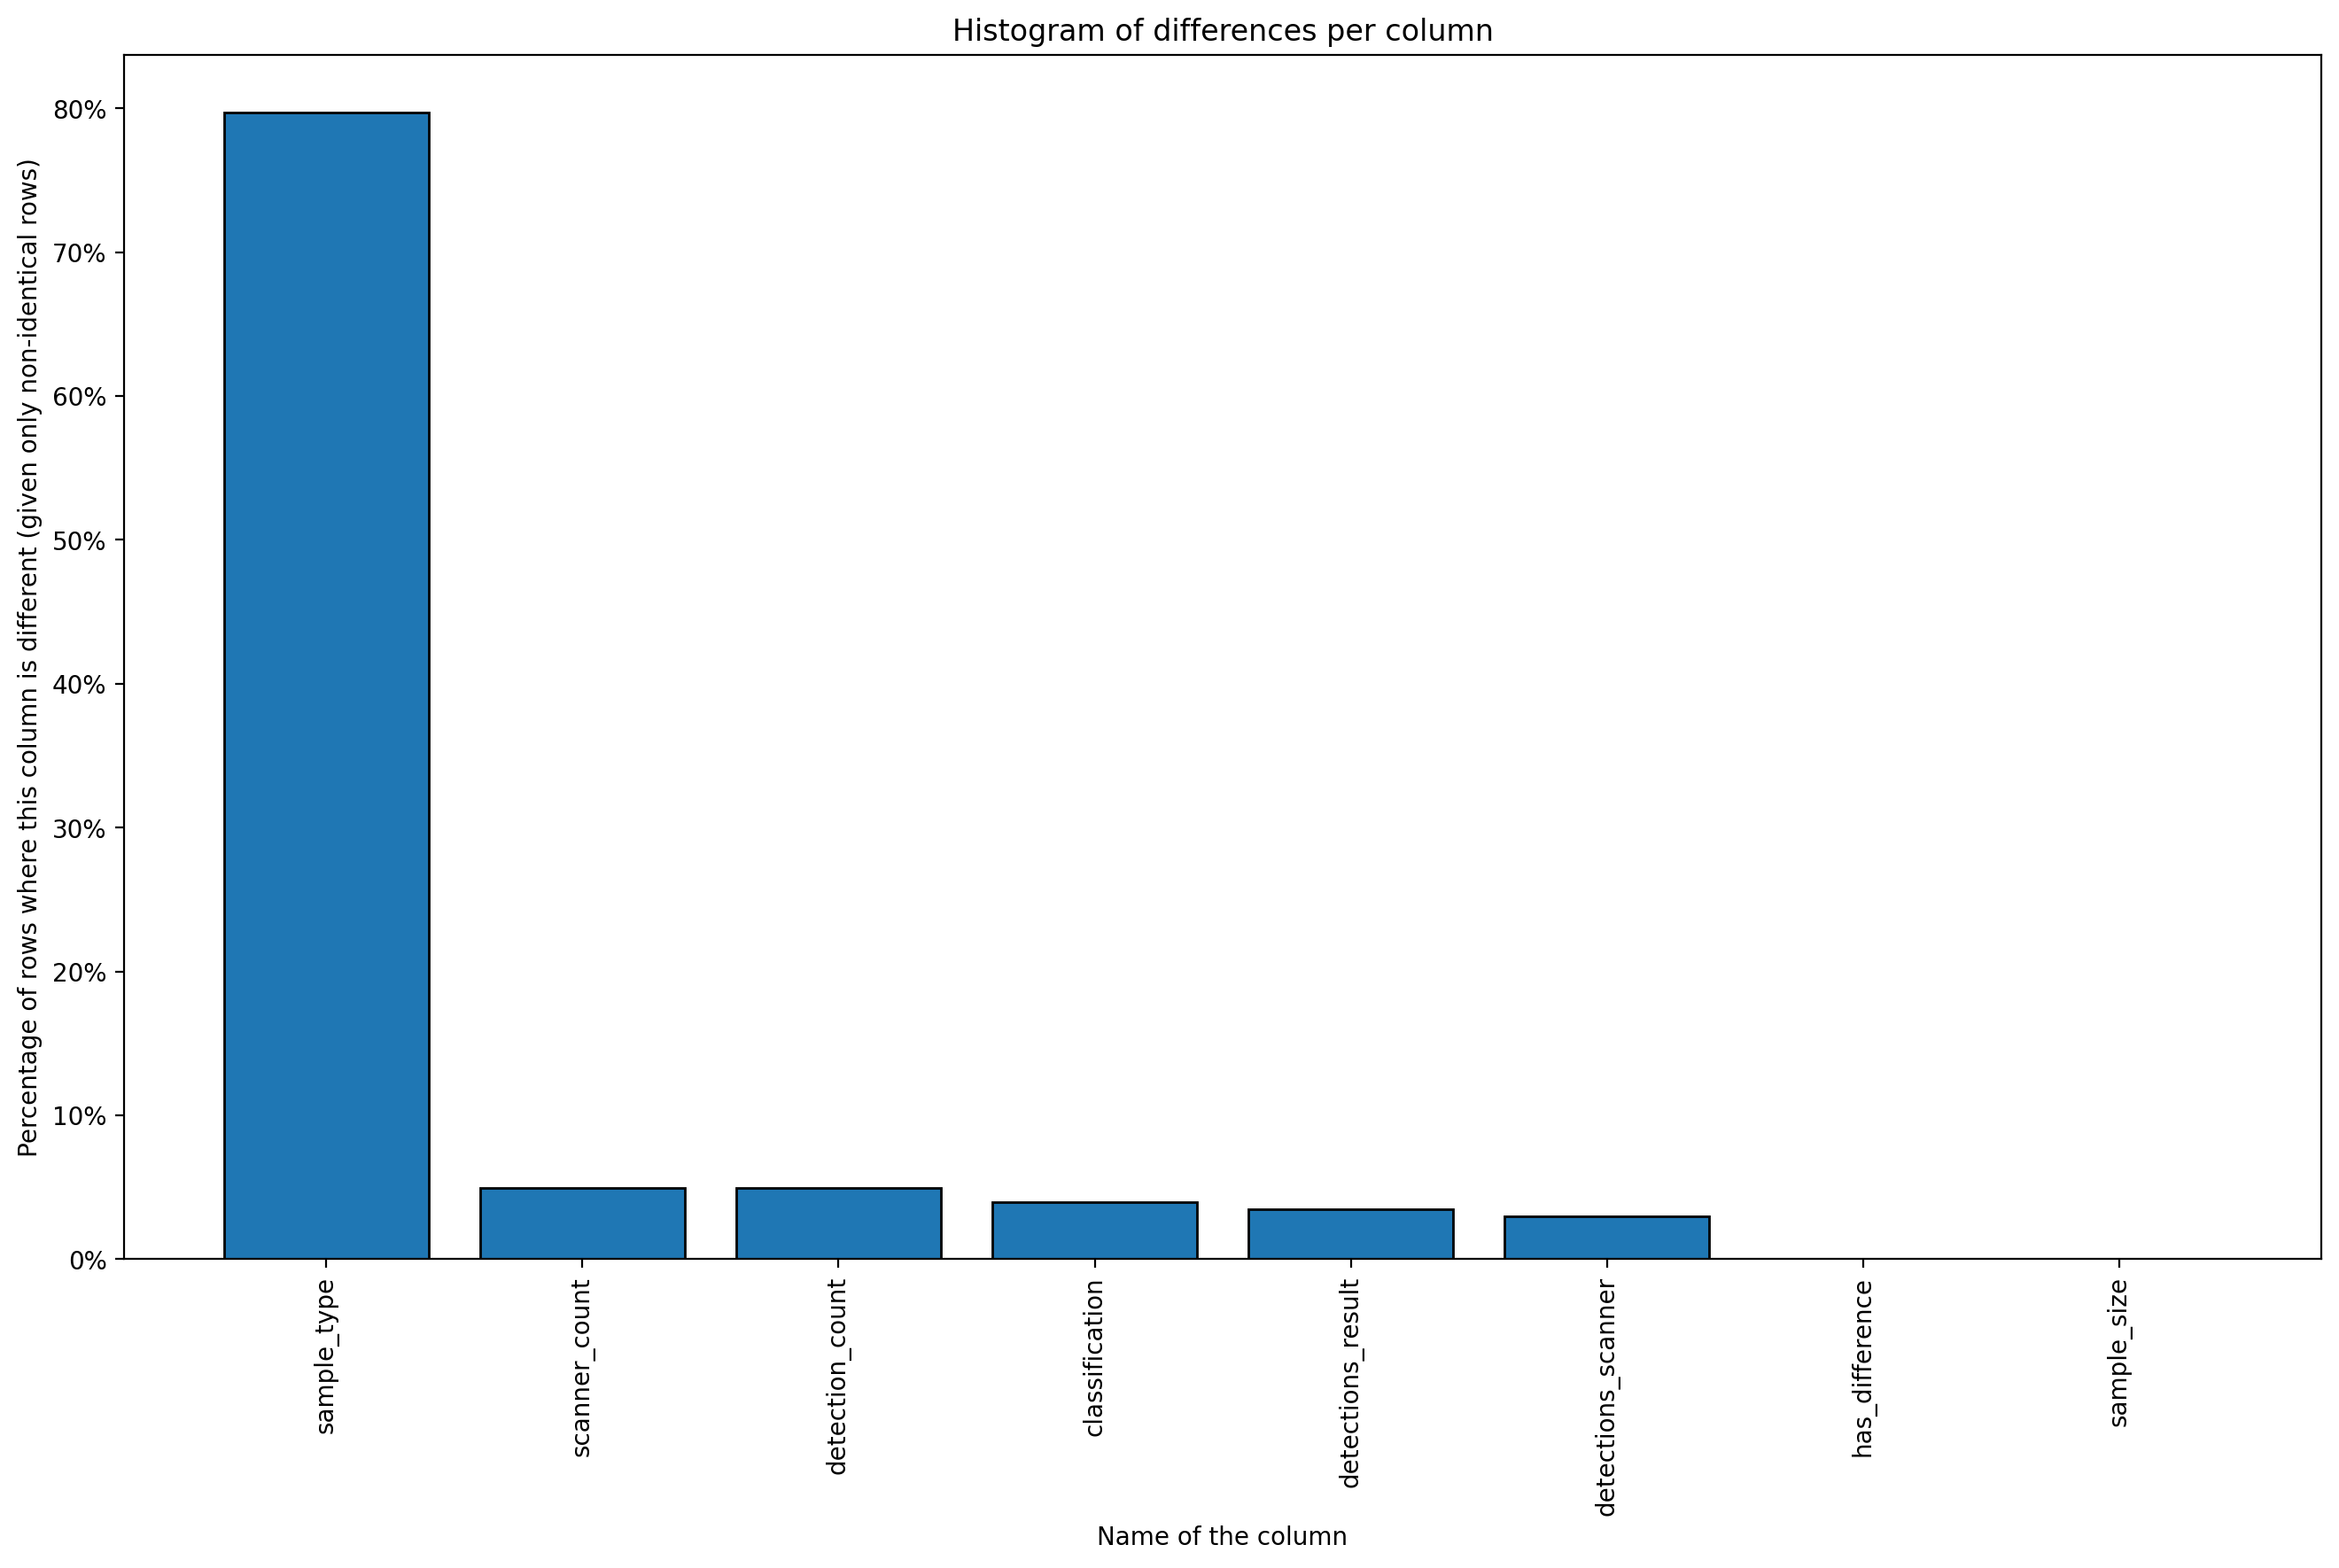

In [29]:
plot_difference_per_column_in_percent(csv_proto_cols)

# Visual Comparison of all three: CSV JSON and PROTOBUF

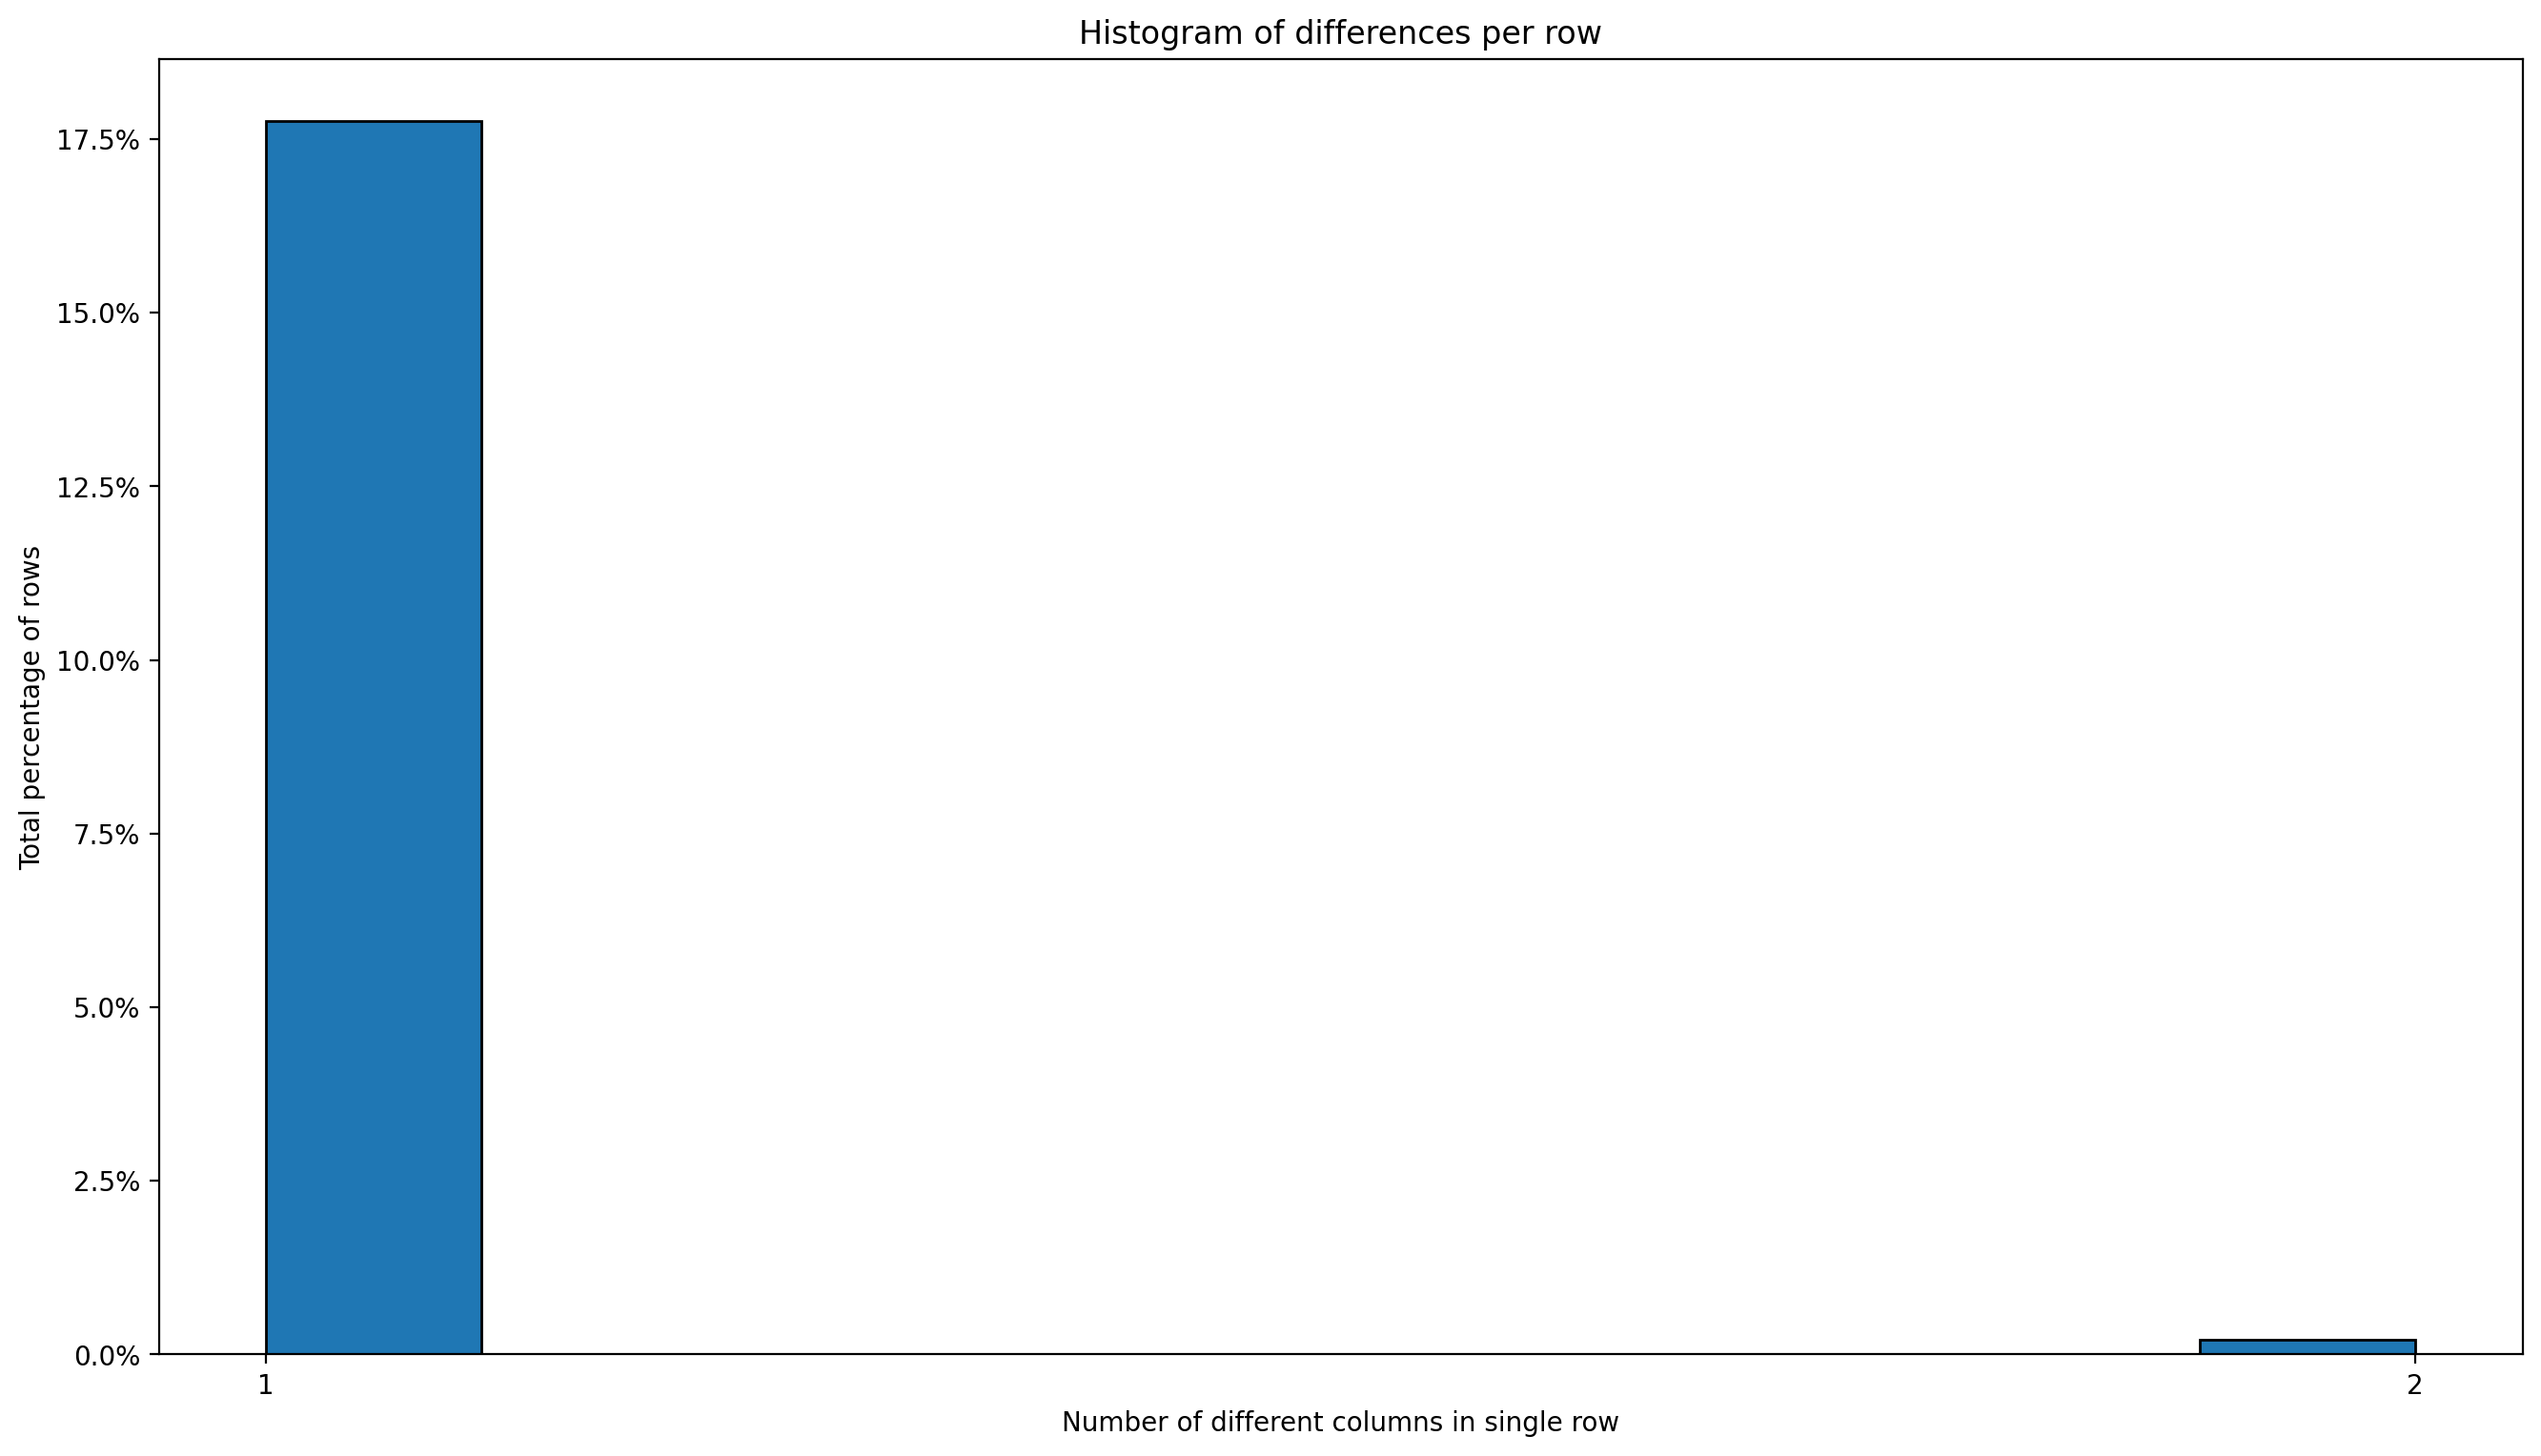

In [30]:
plot_number_of_difference_per_row_in_percent(final_df)

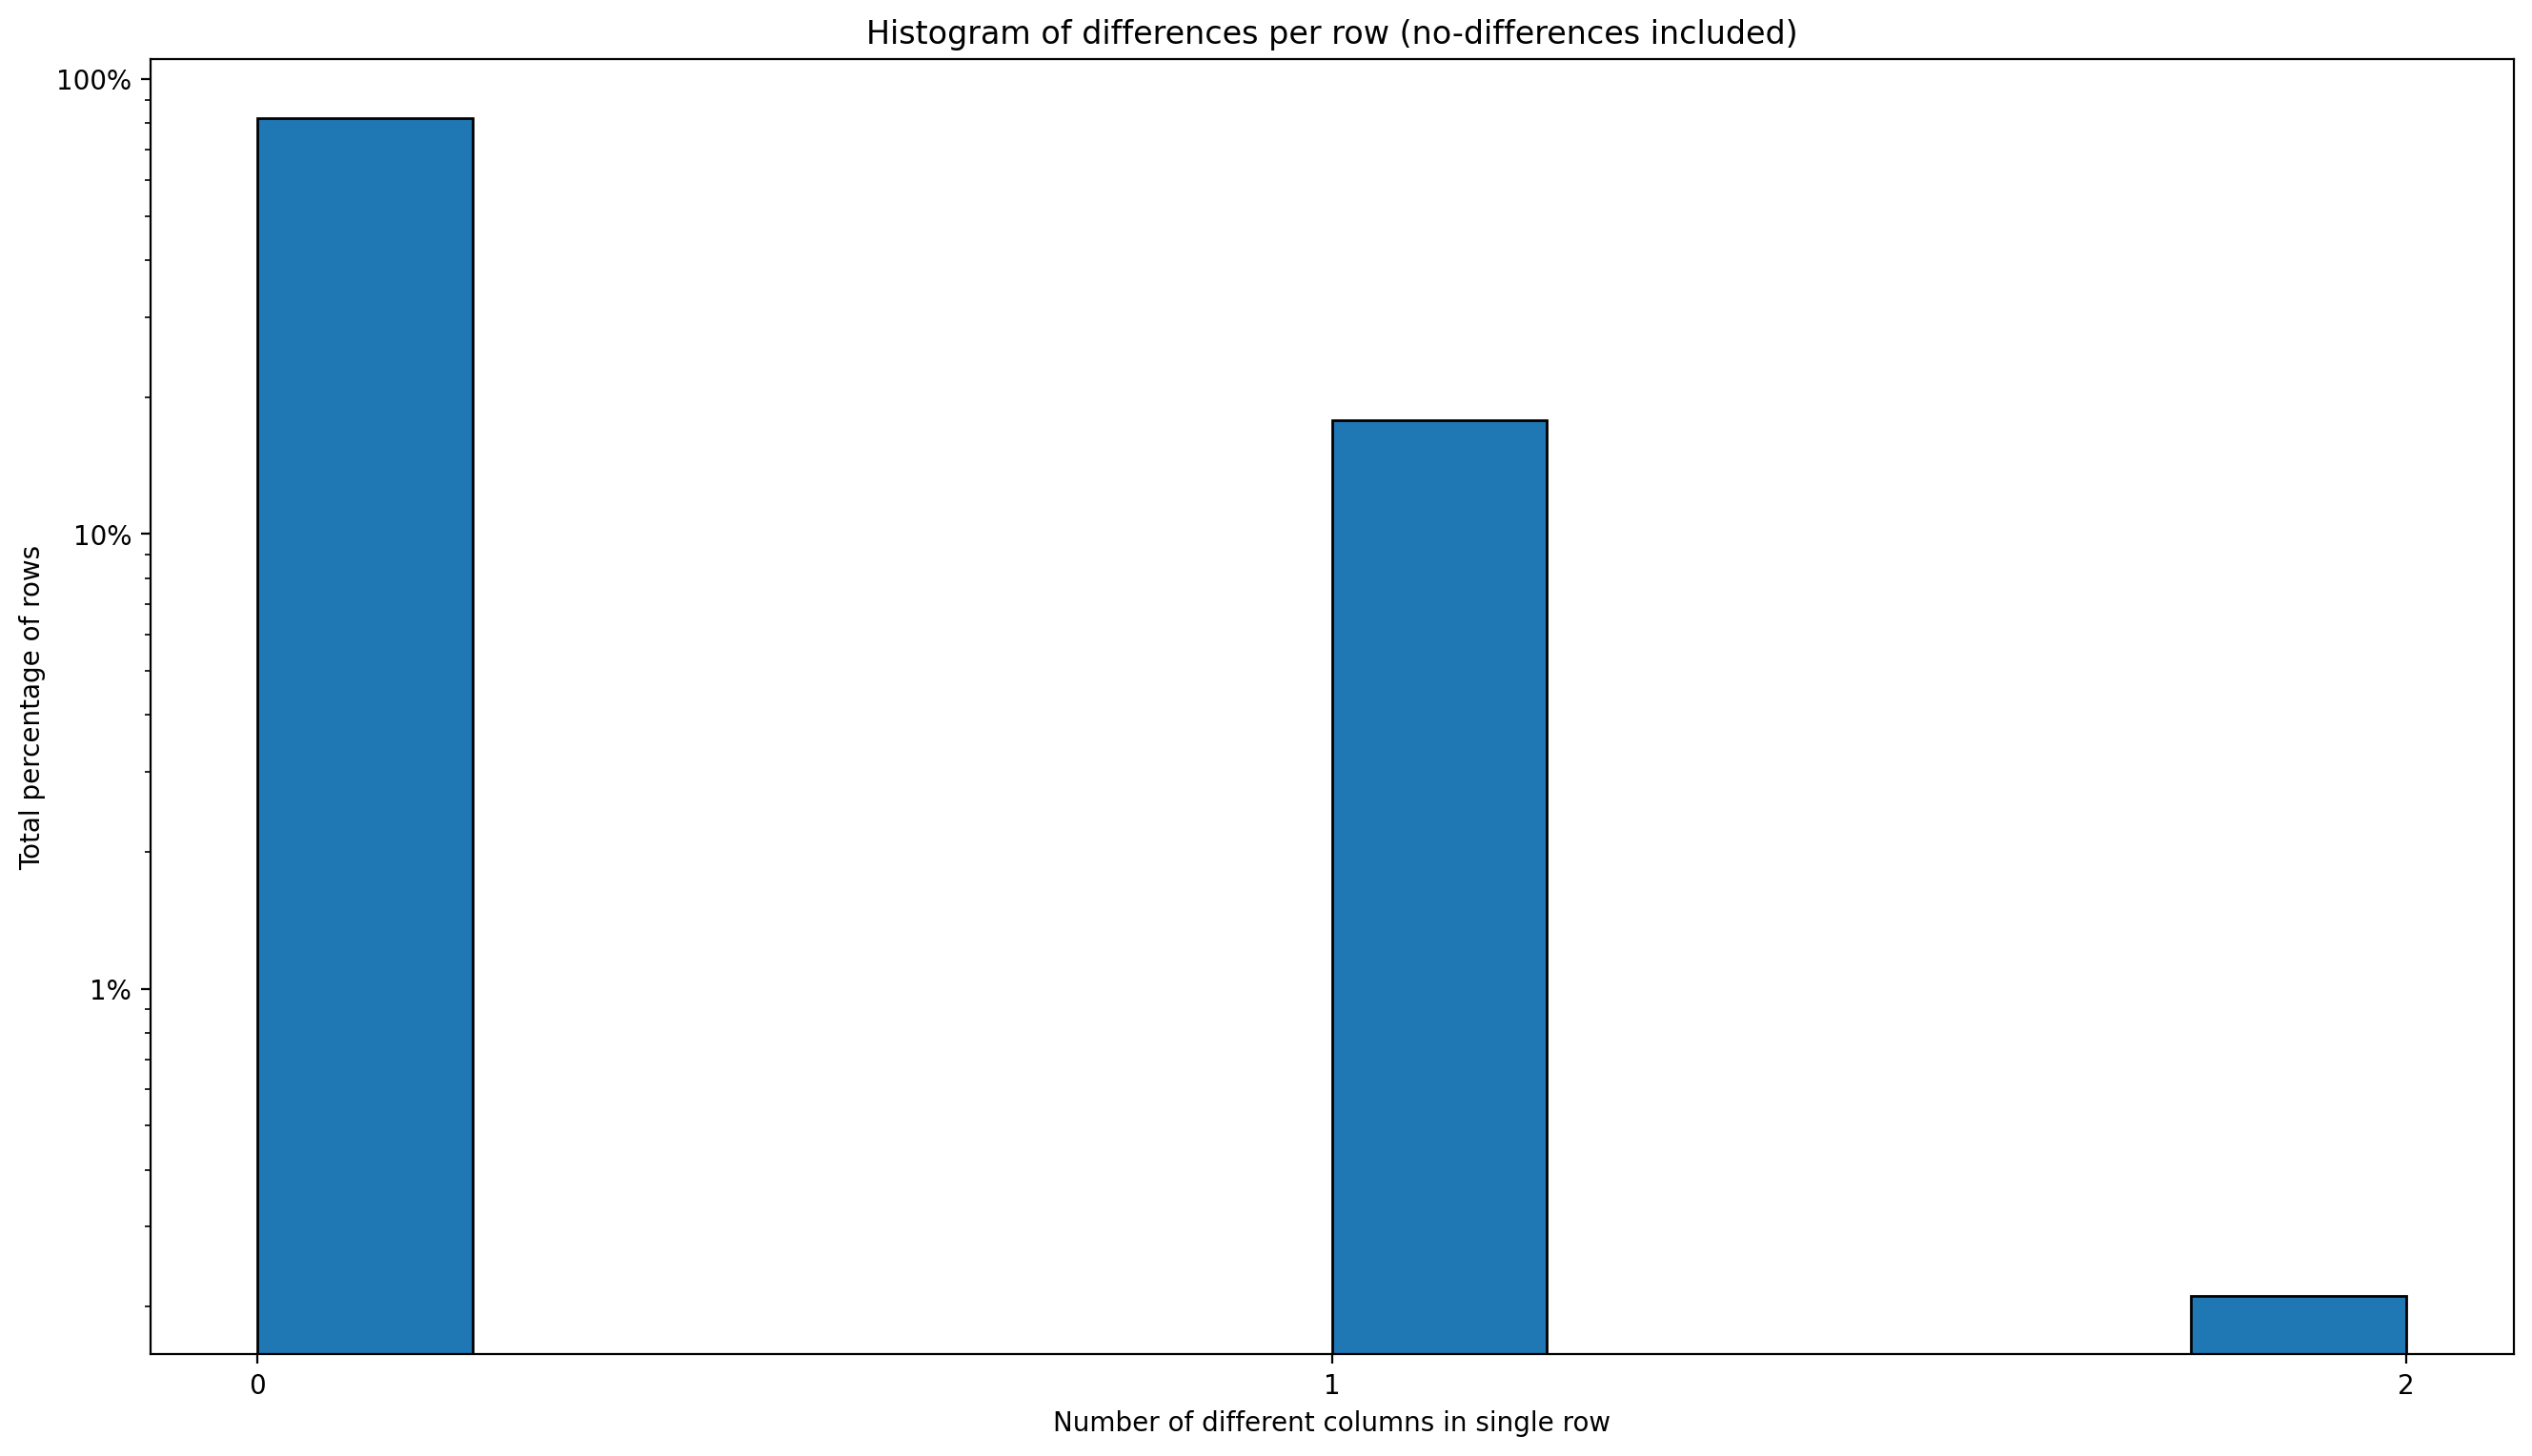

In [31]:
plot_total_number_of_difference_per_row_in_percent(final_df)

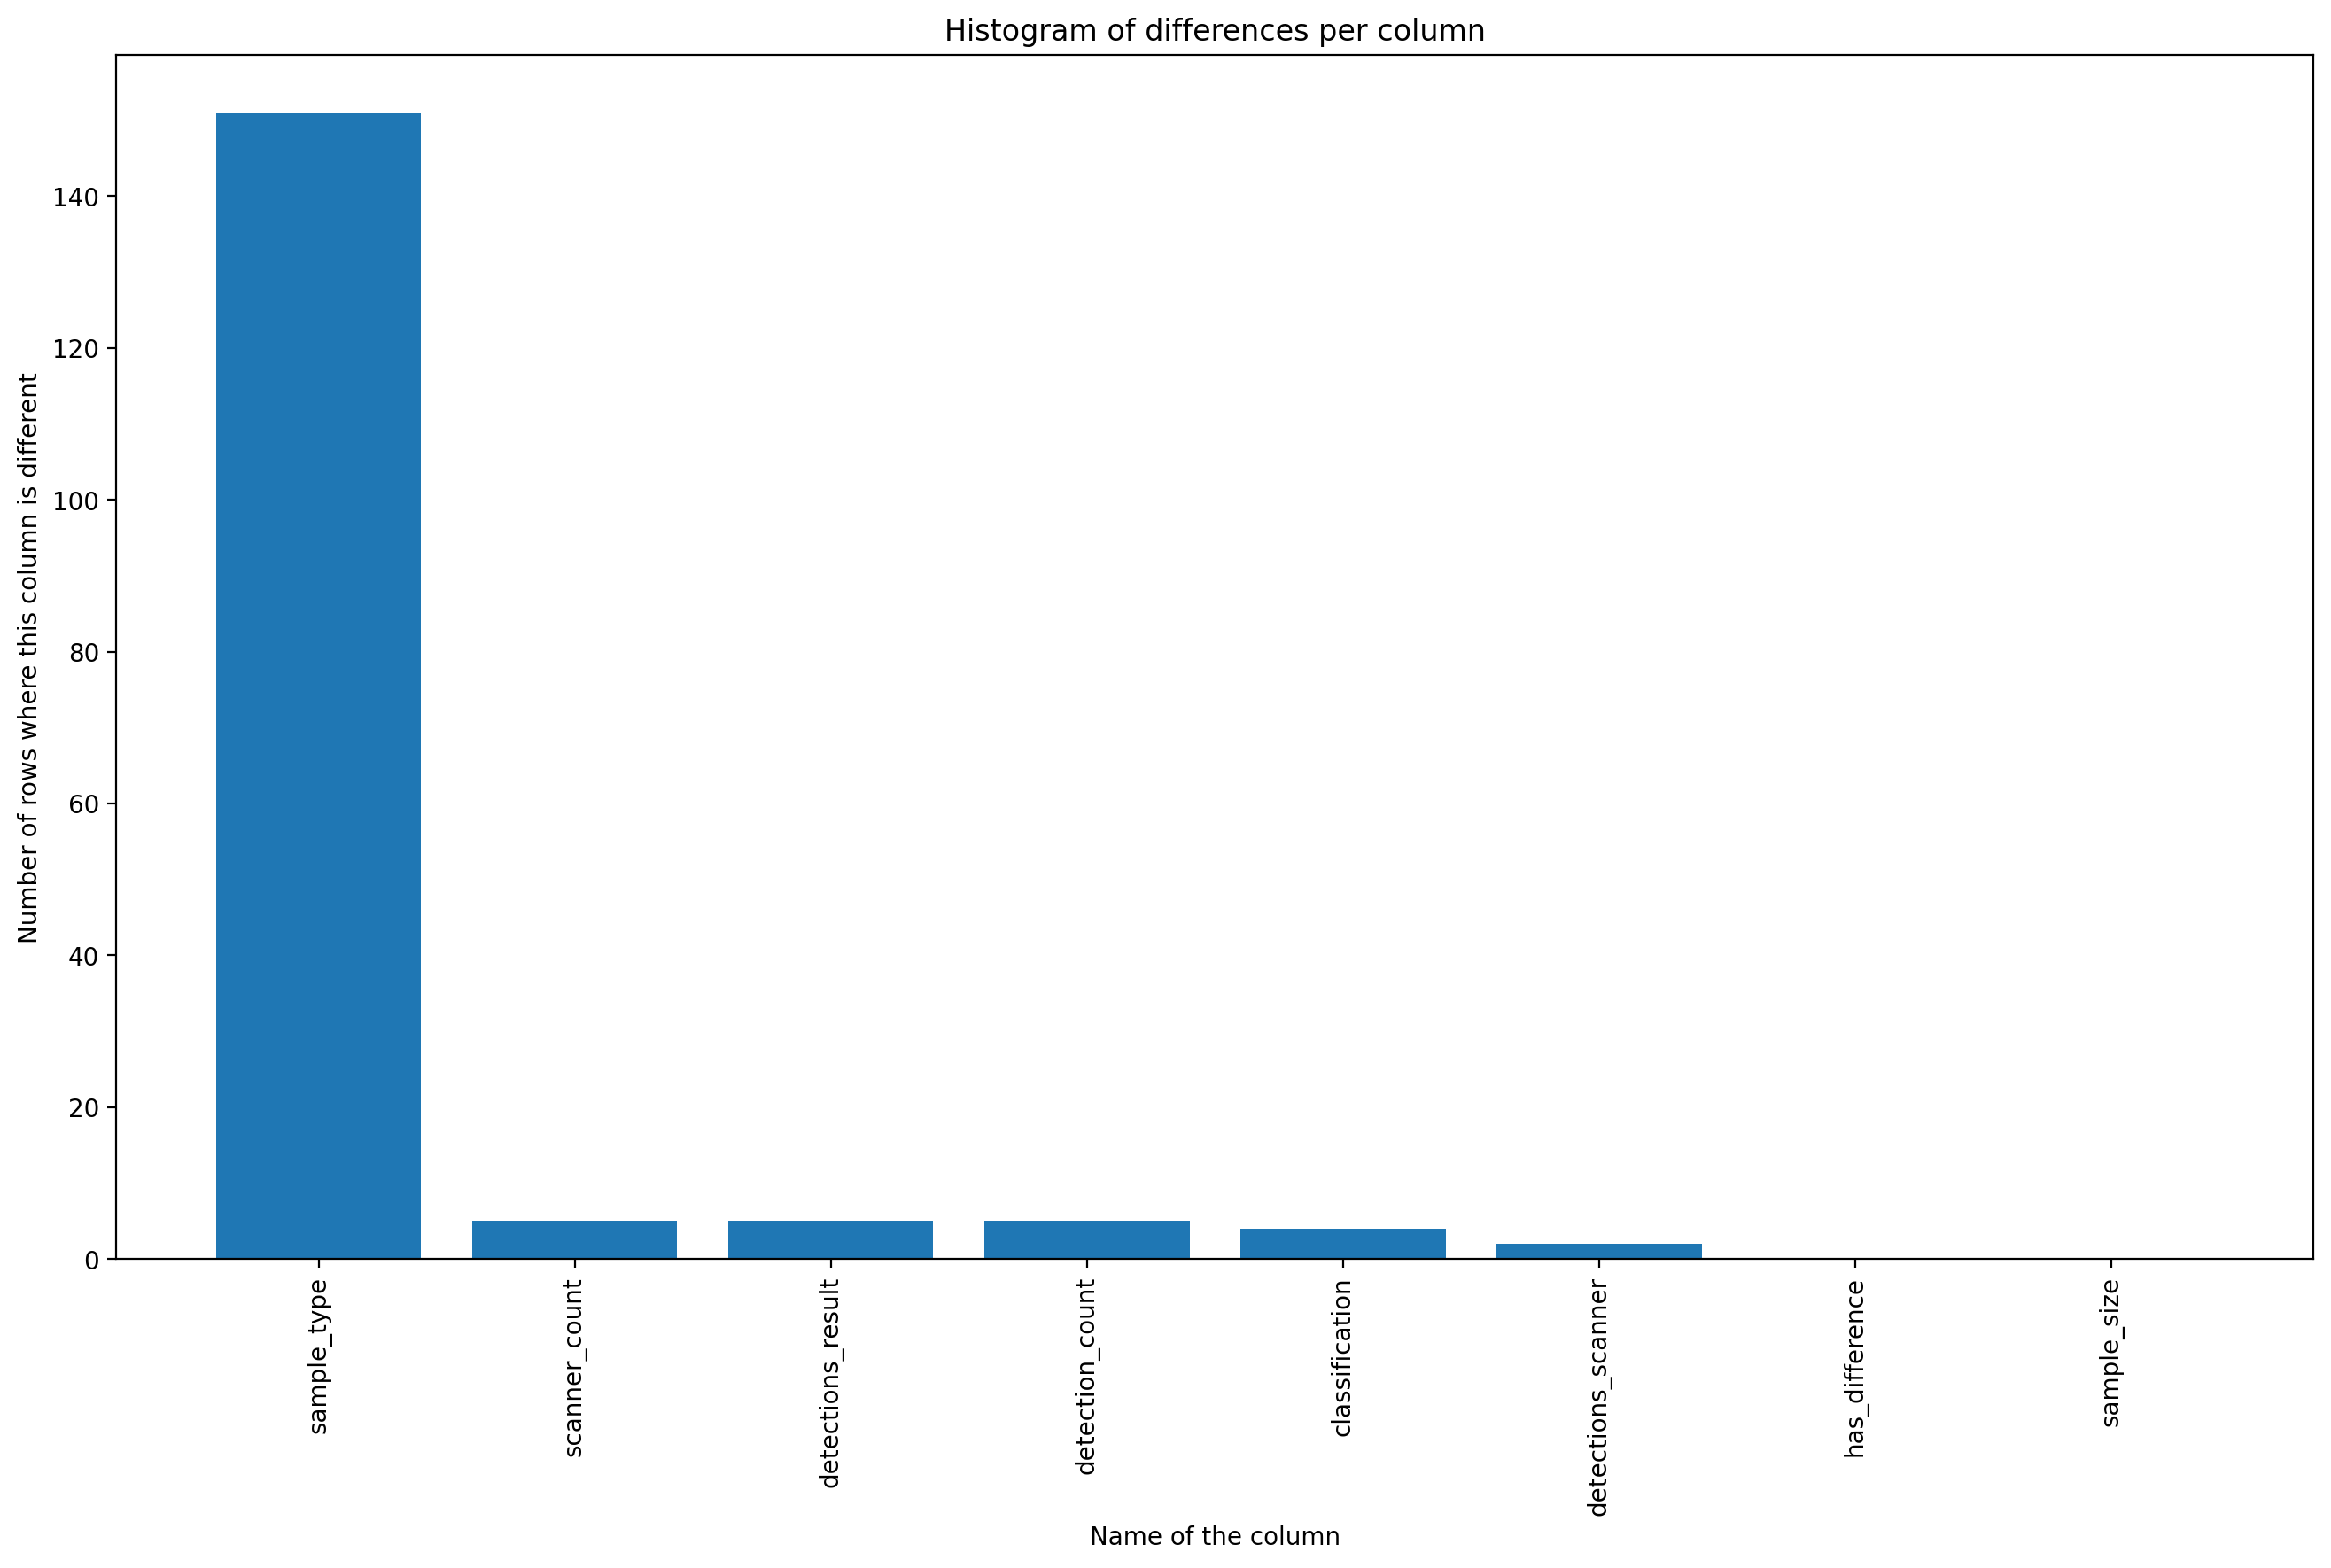

In [32]:
plot_difference_per_column(final_columns)

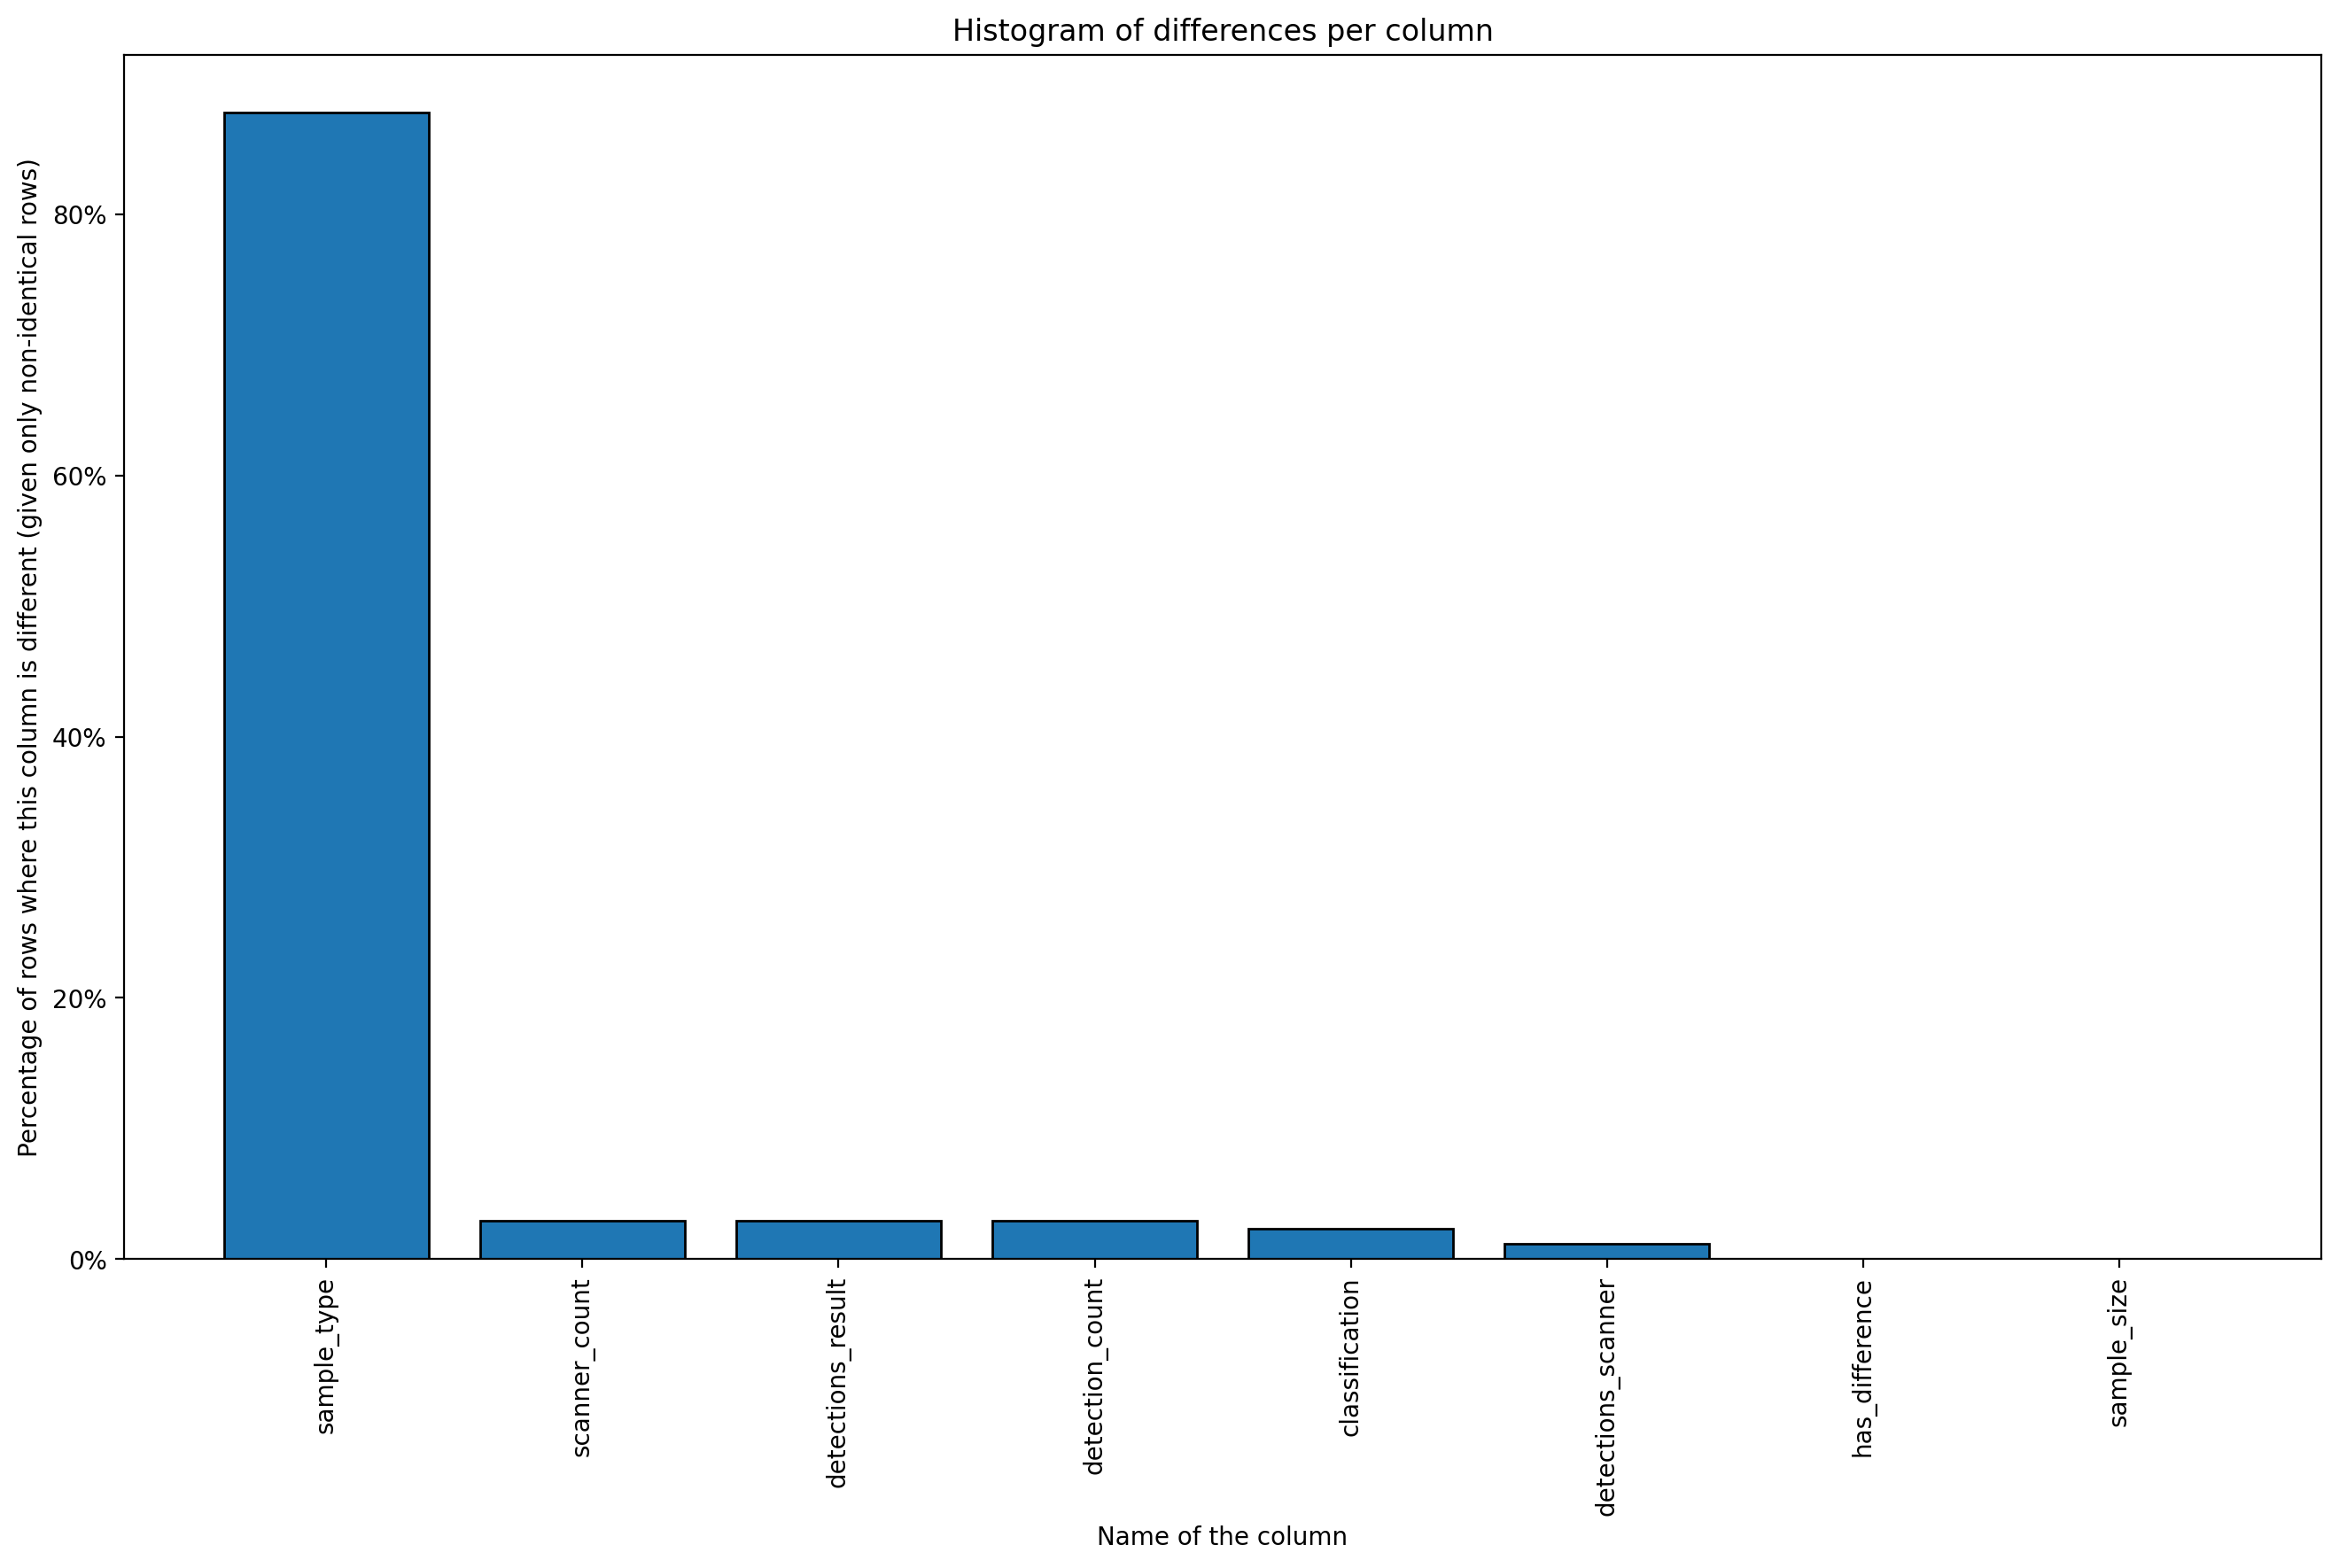

In [33]:
plot_difference_per_column_in_percent(final_columns)

# Conclusion

Most data rows are identical across the data source (CSV, JSON, PROTOBUF) when looking at the same columns.

JSON and PROTOBUF data have a column named 'level' while CSV does not.
Other columns are the same, while their inner formatting is not (CSV has some data prepared for python2).
Details of differences across data sources are in the report above. 


Changes appeared in sample_type column most of the time, so it looked like some data is missing.


Most rows that are different across data source are different in a single column, while some small amount is different in two columns.